<a href="https://colab.research.google.com/github/yucachen/MLTSA25_YChen/blob/main/HW4/PLAsTICC_GP_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Homework Breakdown:**

Skyler Lindsey completed tasks 1 and 2, the data acquisition and exploration. Yuca Chen and Jacklyn Clauss worked together on task 3, extracting the features, and the Gaussian processes.
Dayanara Yanez followed along with the code and worked on the extra credit task.

**Start of Homework:**


This is an exercise on feature extractoin and Gaussian Processes interpolation of sparse time series.

## OVERVIEW

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in light emission in 6 different bands (i.e. wavelength ranges). The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023).

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good friend Gautham Narayan) to get started and ingest and preprocess the PLASTiCC challenge data. If you are not familiar with classes (object oriented syntax) do not worry about it: I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and fit the time series with Gaussian Processes.



In [205]:
import pandas as pd
import numpy as np
import pylab as pl
import os
import json
import matplotlib.pyplot as plt

%pylab inline


Populating the interactive namespace from numpy and matplotlib


# TASK I :  Data Acquisition
 You can download the data from kaggle
 --- https://www.kaggle.com/c/PLAsTiCC-2018

 The data on zenodo seems to be broken
 --- https://zenodo.org/record/2539456#.XonrIdNKjOQ

 You are only interested in the dataset called _plasticc_train_lightcurves.csv.gz_ and the correspondingn metadata _plasticc_train_metadata.csv.gz_ (note: metadata literally means data about the data)
 or if you get data from Kaggle (preferred) called
 _training_set.csv_ and _training_set_metadata.csv_

 The data is also in my drive at the link https://drive.google.com/file/d/1-M_xvSnZG0x26vsOPU4fS9HX3KQNu3y7/view?usp=sharing - from this name you can figure out how to read the data in with the package gdown.

**Preferred**: you can get the data from kaggle as (mind you, it will take some time! after downloading you want to _unzip_ the data)

`!kaggle competitions download -c PLAsTiCC-2018`

but you need to agree to the terms of competition first
https://www.kaggle.com/settings

In [206]:
# !pip install kaggle

In [207]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [208]:
os.chdir('/content/drive/MyDrive')
#/
# kaggle
# os.chdir('.kaggle')
# os.chdir('MLTSA25')

In [209]:
# ls

In [210]:
# envs = json.load(open("kaggle.json", "r"))
# os.environ["KAGGLE_USERNAME"] = envs['username']
# os.environ["KAGGLE_KEY"] = envs['key']

Run the following three only if you haven't made the MLTSA25 folder yet

In [211]:
#cd ..

In [212]:
#!mkdir MLTSA25

In [213]:
#cd MLTSA25

In [214]:
cd MLTSA25

/content/drive/MyDrive/MLTSA25


In [215]:
# !mkdir HW4

In [216]:
cd HW4

/content/drive/MyDrive/MLTSA25/HW4


In [217]:
# !kaggle competitions download -c PLAsTiCC-2018
'''
Skyler, 12:36pm, 3/9/2025
For others trying to get the data this way, you need to hit "Late Submission" on the competition page to accept the terms. You'll need to link you phone number too.
'''

'\nSkyler, 12:36pm, 3/9/2025\nFor others trying to get the data this way, you need to hit "Late Submission" on the competition page to accept the terms. You\'ll need to link you phone number too.\n'

In [218]:
ls

training_set.csv  training_set_metadata.csv


In [219]:
# !unzip PLAsTiCC-2018.zip #This takes a while to run

In [220]:
# ls

In [221]:
lcvs = pd.read_csv("training_set.csv")

In [222]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [223]:
print("The shape of light curves dataset is:", lcvs.shape)

The shape of light curves dataset is: (1421705, 6)


In [224]:
#check missing values
lcvs.isna().sum()

,0
object_id,0
mjd,0
passband,0
flux,0
flux_err,0
detected,0


Read the Kaggle challenge for a description of the data . This "Starter Kit" which includes a notebook (written by y good friend Gautham Narayan) may be especially useful
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit

For each object there are 6 time series in 6 different passbands: those are different wavelength ranges over which we observe light (e.g. r is roughtly the wavelengths corresponding to the red portion of the rainbow)

In [225]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [226]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [227]:
metadata = pd.read_csv("training_set_metadata.csv")
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [228]:
print("The metadata columns are: ", metadata.columns)

The metadata columns are:  Index(['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target'],
      dtype='object')


In [229]:
print("The metadata dataset contains features: ", metadata.shape[1])

The metadata dataset contains features:  12


# TASK II : data exploration and visualization - plot some time series
Visualize my data to get a sense of what we are working with.





Plot light curves for 10 objects.

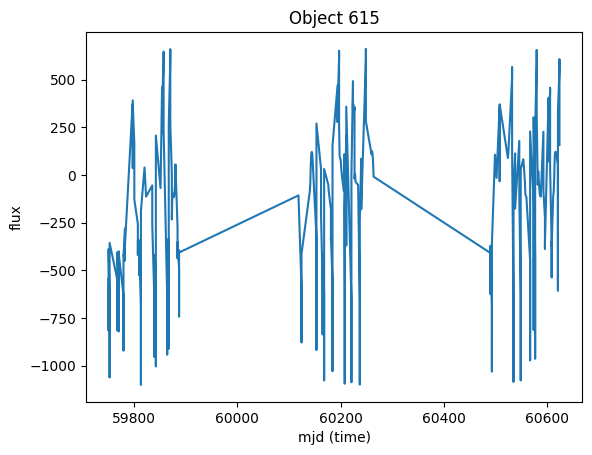

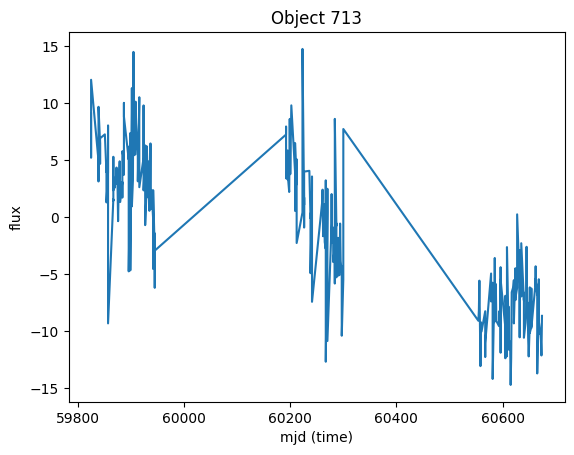

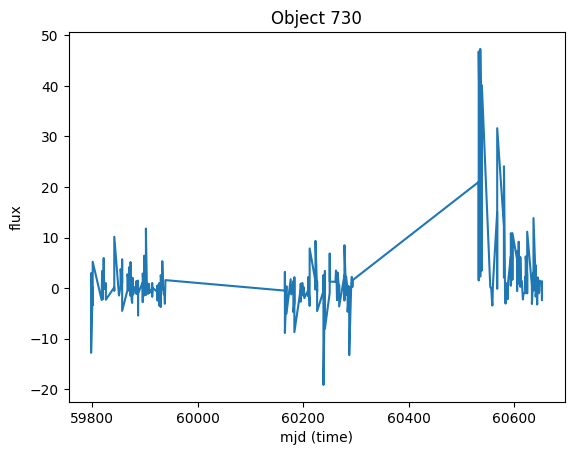

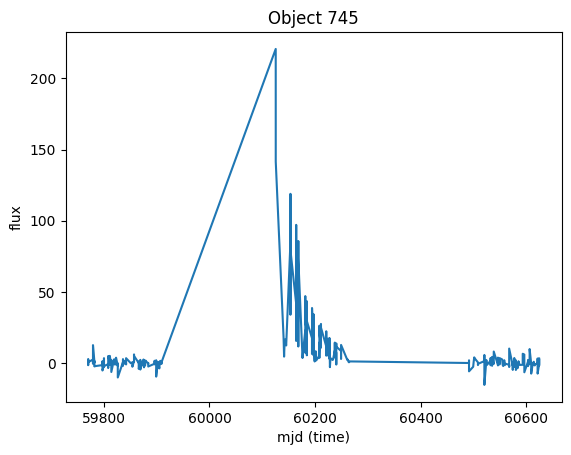

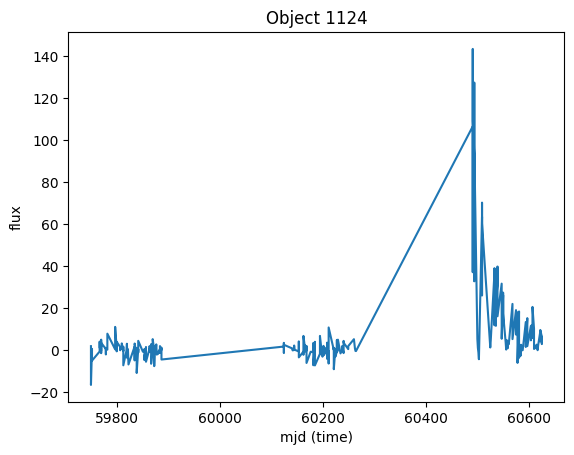

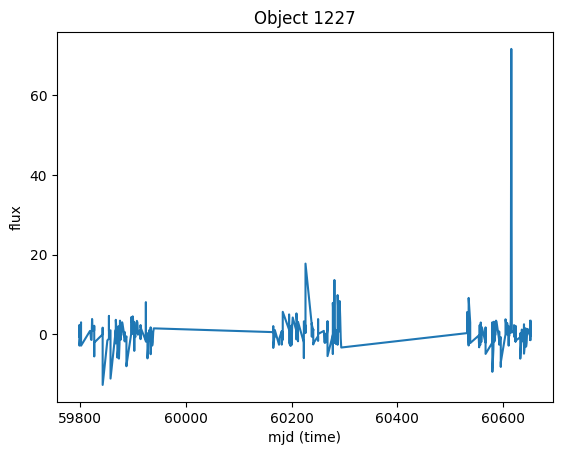

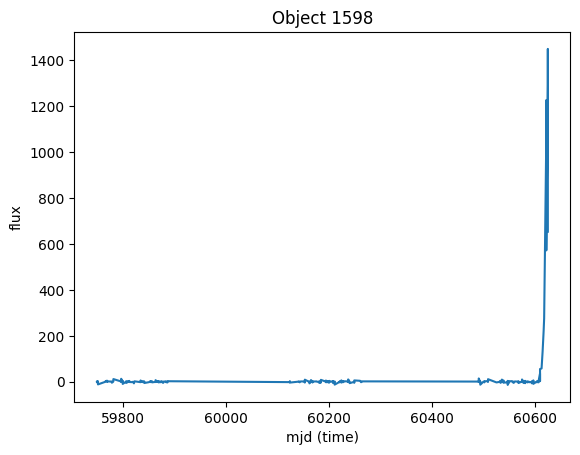

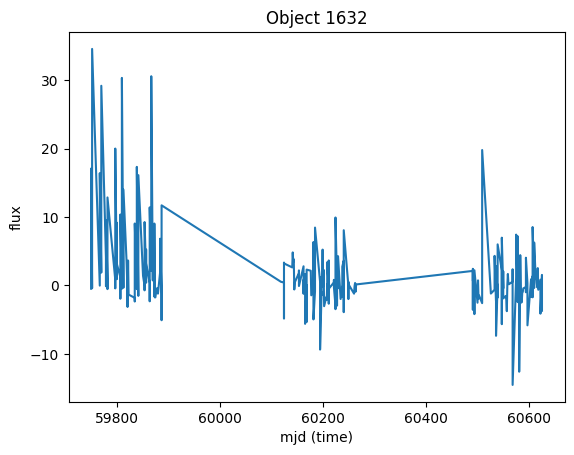

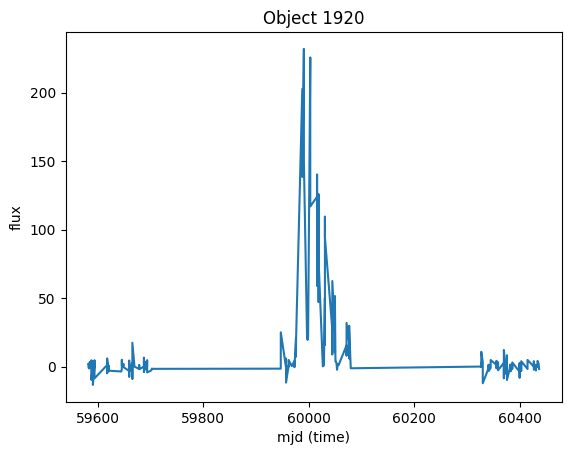

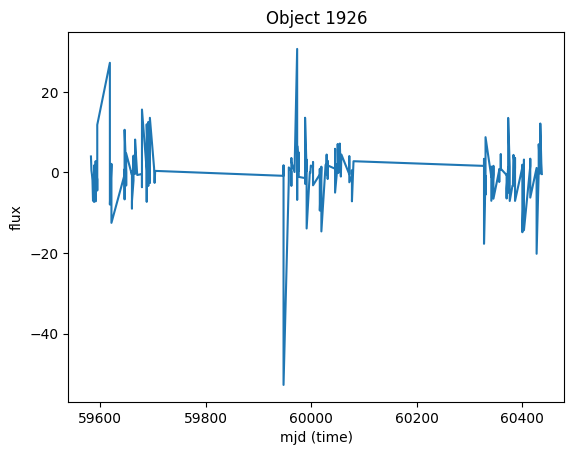

In [230]:
datalist = lcvs["object_id"].unique()[:10]
for x in datalist:
  plt.plot(lcvs[lcvs["object_id"] == x]["mjd"], lcvs[lcvs["object_id"] == x]["flux"])
  plt.xlabel('mjd (time)')
  plt.ylabel('flux')
  plt.title('Object {}'.format(x))
  plt.show()

**Figure 1:** Ten distinct celestial objects' light curves are shown in these graphics, which show how their flux, or brightness, changes over time. The y-axis displays flux, which is the measured brightness of each object, while the x-axis displays the Modified Julian Date (mjd).  Every plot sheds light on how the object's brightness changes over time. While some objects show dramatic outbursts, dips, or random changes, others show continuous brightness, which could indicate many astrophysical processes.

Plot explicitly object 84716

YOUR CODE HERE

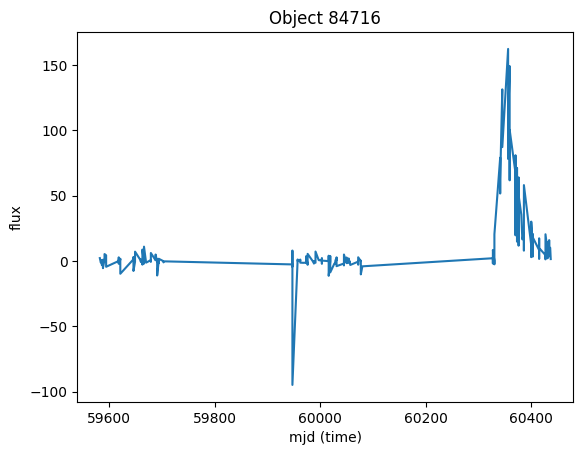

In [231]:
plt.plot(lcvs[lcvs["object_id"] == 84716]["mjd"], lcvs[lcvs["object_id"] == 84716]["flux"])
plt.xlabel('mjd (time)')
plt.ylabel('flux')
plt.title('Object {}'.format(84716))
plt.show()

**Figure 2:** The light curve of Object 84716 is shown in this figure. The MJD, is shown by the x-axis, and flux, which shows the object's brightness as measured over time, is represented by the y-axis. The light curve shows an intriguing pattern: a steady flux at first, followed by an abrupt decrease, a slow increase, and a notable peak close to mjd 60400, before declining once more. This raises the possibility of a brief astrophysical occurrence.

# TASK III: Extract features

Feature extraction refers to the extraction of statistical features of the datapoints or the generation of low dimensional representations of the data points that can then be passed to a classifier/regression

Extract at least 4 features including at least 1 feature from all three category below

The code that won the callenge did a number of smart things, of course. It was a feature based classification scheme, which included Gaussian Processes in the preprocessing. The feature extraction part of the code is here. https://github.com/kboone/avocado/blob/master/avocado/plasticc.py

Examples of features you can extract:

- **from the original lightcurve**:
    - mean,
    - standard deviation,
    - skewness,
    - kurthosis,
    - minimum
    - maximmum,
    - error on the minimum and
    - error on the maximum,
- **from the standardized lightcurve**:
    - median
    - slope of a line fit
    - intercept of a line fit
    - likelihood of the line fit
    - likelihood of a quadratic fit
    - sign of the quadratic parameter


- **from the metadata file**:
    - decl; this is one of the positions in the sky variables: important because the position on the sky may determin if it is a galactic or extragalactic object
    - ddf_bool ; the kind of survey i.e. the data collection scheme that lead to the time series
    - hostgal_photoz
    - hostgal_photoz_err
    
The feature in the metadata files are the hardest ones to decide on because they require domain knowledge.
Most of the other features in the metadata are unknown for test objects (only known for the training set)


Extract at least 4 features including 1 features from all three category above: original lcv, standardized lcv, metadata. Justify each feature. Coming up with different features than the ones I suggested is very welcome! Remember that if the features are extracted from the time series there will be 4 features for each passbands.

Note: we are working with bigg-ish data!
First off: every new piece should be developed on a subset of the dataset, then run on all the data only when ready.
Still, if you try achieve goals by implementing for loops you are not going to be able to run the notebook for the whole data, or even only 1 batch of the full datase. A good solution is to use the groupby() method in pandas. I used groupby everywhere. Also it may be wise to write out intermediate outputs, so you do not have to loose work if your kernel dies or something similar.


describe each feature you plan to extract. Briefly indicate why you think it is a valuable feature and what data type is it (e.g. continuous, binary, categorical, if continuous does it have a max or min value or is it unbound?)

        

**Features we plan to extract:** From the raw lightcurves we will extract the mean and standard deviation. From the standardized lightcurve we will extract the median. From the metadata we will extract the declination.

**Why we choose these to extract:** We decided to extract the mean and standard deviation from the raw light curves as these values are used to standardize the light curves. From the standardized lightcurve we chose to extract the median and the slope of the line fits of each curve. The median of the lightcurve tells us how far off from zero the “center of mass” of the data is. The slope of the line fits of each curve will help to tell us the general shape of the data. We also chose to extract the declination of the object from the metadata. This helps to tell us whether the object is galactic or extragalactic which is another interesting parameter to have.




### extract some features from the raw lightcurve -


higher order moments of the distribution can be obtained with the scipy.stats.moment() function which can be applied to a grouby() object
note that this way you can apply a function that takes only one argument, the argument over which groupby iterates (the flux here). But moments take 2: the value and the moment Create a function call

In [232]:
#example
means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()

In [233]:
means

flux
object_id passband             
615       0           -3.254554
          1         -385.699911
          2         -134.146566
          3         -121.103501
          4          -55.954592
...                         ...
130779836 1          725.169852
          2         2690.360415
          3          755.993902
          4         3489.185336
          5         4151.358875

[47088 rows x 1 columns]

In [234]:
#example
from scipy import stats

# this will give us the variance of the given x
def m2(x):
    return stats.moment(x, moment = 2)


In [235]:
# find the standard deviations
stds = lcvs.groupby(["object_id", "passband"])[["flux"]].std()
stds

flux
object_id passband              
615       0            83.944735
          1           601.787302
          2           455.121346
          3           335.425053
          4           291.803449
...                          ...
130779836 1          1197.557111
          2          6440.422386
          3          1443.868085
          4         11006.766106
          5          8687.101173

[47088 rows x 1 columns]

Even with the same standard deviation two distribution can be very different.
Look at the this article for a great demonstation of that! https://heap.io/blog/data-stories/anscombes-quartet-and-why-summary-statistics-dont-tell-the-whole-story

I extracted  the max and min, but also their uncertainties because outlier points may be measurement issues, in which case the uncertainty may be large : see the plot you made for 84716!

If a distribution has spikes the standard deviation will be larger even if the other datapoints are exactly the same. Save the mean and the max of both original distribution and the standardized one (standardized = mean subtracted and divided by the standard deviation).


Standardize the lcvs and extract some features from the raw lightcurve -


You can do it use  the preprocessing.scale function and groupby, which group by object and band. It does its job, but it is slow

In [236]:
# prompt: standardize the light curves in lcvs (subtract the means (means) and divide by the standard deviations (stds) using the mean and standard deviation we already calculated)

# Standardize the light curves
lcvs['flux_standardized'] = lcvs.groupby(['object_id', 'passband'])['flux'].transform(lambda x: (x - x.mean()) / x.std())


In [237]:
# find the means for the standardized light curves (should be 0!)

means_stand = lcvs.groupby(["object_id", "passband"])[["flux_standardized"]].mean()
means_stand

# the means are extremely close to 0 so this is acceptable

flux_standardized
object_id passband                   
615       0              3.876969e-17
          1              9.570888e-17
          2              4.976862e-17
          3             -3.828355e-17
          4              1.531342e-17
...                               ...
130779836 1              3.700743e-17
          2             -1.176836e-16
          3              1.160688e-16
          4             -2.775558e-17
          5              5.551115e-17

[47088 rows x 1 columns]

In [238]:
# find the standard deviations for the standared deviation (should be 1!)
stds_stand = lcvs.groupby(["object_id", "passband"])[["flux_standardized"]].std()
stds_stand
# the standard deviations are 1 so the curves have been properly standardized!!!

flux_standardized
object_id passband                   
615       0                       1.0
          1                       1.0
          2                       1.0
          3                       1.0
          4                       1.0
...                               ...
130779836 1                       1.0
          2                       1.0
          3                       1.0
          4                       1.0
          5                       1.0

[47088 rows x 1 columns]

In [239]:
#?
#print("Mean:", mean_norm)
#print("Standard Deviation:", std_norm)

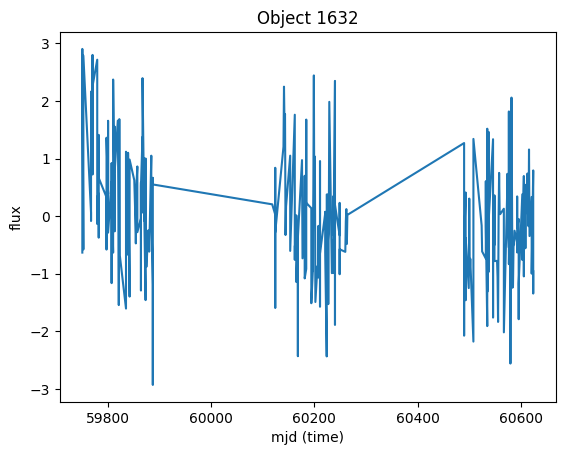

In [240]:
# plot a standardized lc for testing!
plt.plot(lcvs[lcvs["object_id"] == 1632]["mjd"], lcvs[lcvs["object_id"] == 1632]["flux_standardized"])
plt.xlabel('mjd (time)')
plt.ylabel('flux')
plt.title('Object {}'.format(1632))
plt.show()

**Figure 3:** The standardized light curve for the astronomical object 1632 is displayed in this picture, which illustrates how its brightness(standardized flux) changes with time (mjd). The information was taken from the lcvs dataset, which normalized brightness variances across several passbands by standardizing flux values.  Plotting shows notable oscillations, indicating that object 1632 might be a naturally fluctuating source.

Note: the median of the standardizeed distribution would convey the location of the "center of mass" of the data with respect to the mean


In [241]:
#find the median of the standardized light curves
medians = lcvs.groupby(["object_id", "passband"])[["flux_standardized"]].median()

medians

flux_standardized
object_id passband                   
615       0                 -0.080537
          1                 -0.170090
          2                 -0.289021
          3                 -0.122434
          4                 -0.163078
...                               ...
130779836 1                 -0.513972
          2                 -0.355787
          3                 -0.406302
          4                 -0.309318
          5                 -0.416662

[47088 rows x 1 columns]

parametric features: extract some features that come from simple models of the lightcurve, e.g. line fits



In [242]:
# prompt: extract the slope of lines fit to 'flux_standardized' for the lightcurves in  lcvs

# extract the slope of the line fits

# Calculate slopes for each object and passband
slopes = lcvs.groupby(['object_id', 'passband']).apply(lambda group: stats.linregress(group['mjd'], group['flux_standardized'])[0])

# Convert the slopes to a DataFrame
slopes_df = slopes.reset_index(name='slope')
slopes_df.groupby(["object_id", "passband"])[["slope"]].mean()

oid = slopes_df['object_id']
slopes_df.index = oid
slopes_df


<ipython-input-242-f5b5e6bdb670>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes = lcvs.groupby(['object_id', 'passband']).apply(lambda group: stats.linregress(group['mjd'], group['flux_standardized'])[0])


,object_id,passband,slope
object_id,,,
615,615,0,0.000524
615,615,1,0.000559
615,615,2,0.000750
615,615,3,0.000908
615,615,4,0.001037
...,...,...,...
130779836,130779836,1,-0.002528
130779836,130779836,2,-0.001860
130779836,130779836,3,-0.002308


In [243]:
# drop the extra object_id column
slopes_df = slopes_df.drop('object_id', axis=1)
slopes_df

# group the slopes by object id
slopes_df = slopes_df.groupby(["object_id", "passband"])[["slope"]].mean()


In [244]:
slopes_df

slope
object_id passband          
615       0         0.000524
          1         0.000559
          2         0.000750
          3         0.000908
          4         0.001037
...                      ...
130779836 1        -0.002528
          2        -0.001860
          3        -0.002308
          4        -0.001134
          5        -0.001480

[47088 rows x 1 columns]

the goodness of fit for these models is also a potential feature

In [245]:
# get the metadata feature 'decl'
metadata = pd.read_csv("training_set_metadata.csv")
decs = metadata['decl']
oid = metadata['object_id']
#decs = decs.set_index('object_id')
decs = pd.DataFrame(decs)
decs.index = oid
#decs.columns = ['object_id','decl']

In [246]:
decs

,decl
object_id,
615,-61.943836
713,-27.784405
730,-6.579593
745,-45.586655
1124,-63.823658
...,...
130739978,-14.940303
130755807,-62.696659
130762946,-55.682144


Data Organization: you can put all your features in a dataframe using merge at each step merging each new feature with the olde ones


In [247]:
#example
# merge the features into one data frame

features = pd.merge(means, stds, left_index=True, right_index=True)

features = pd.merge(features, medians, left_index=True, right_index=True)

features = pd.merge(features, slopes_df, left_index=True, right_index=True)

features.columns = ['mean', 'standard_deviation', 'median', 'slope']
features.head()

mean  standard_deviation    median     slope
object_id passband                                                    
615       0          -3.254554           83.944735 -0.080537  0.000524
          1        -385.699911          601.787302 -0.170090  0.000559
          2        -134.146566          455.121346 -0.289021  0.000750
          3        -121.103501          335.425053 -0.122434  0.000908
          4         -55.954592          291.803449 -0.163078  0.001037

NOTE: when you merge the metadata features you are going to have to do some gymnastic with the indices: this is because the data has 2 indices columns: the object id and the bandpass id, while the metadata has only 1 index: the object id.

You can use the function unstuck - here is an example line of code of what worked for me **but** it kind of depends on how you organized your dataframe so this is not guaranteed to work!

In [248]:
#allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
 #   ).unstack([1,2])

allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([2,1])
#allfeatures.reindex(allfeatures['object_id'])
allfeatures.shape


(7848, 24)

In [249]:
allfeatures.columns = allfeatures.columns.droplevel(1)
allfeatures.head()

,mean,standard_deviation,median,slope,mean,standard_deviation,median,slope,mean,standard_deviation,...,median,slope,mean,standard_deviation,median,slope,mean,standard_deviation,median,slope
object_id,,,,,,,,,,,,,,,,,,,,,
615,-3.254554,83.944735,-0.080537,0.000524,-385.699911,601.787302,-0.170090,0.000559,-134.146566,455.121346,...,-0.122434,0.000908,-55.954592,291.803449,-0.163078,0.001037,-47.449847,294.779522,-0.129163,0.001003
713,-2.720398,7.113509,-0.052914,-0.002859,-1.019804,5.712334,0.080189,-0.002799,-0.794238,5.770738,...,0.141552,-0.002748,-0.900262,6.406989,0.016870,-0.002681,-1.794175,7.094073,-0.094281,-0.001978
730,-0.048080,1.828872,0.039463,-0.000121,0.141057,1.807229,0.016754,0.000337,2.400870,5.559483,...,-0.314425,0.001578,4.308728,10.710344,-0.308522,0.001477,4.539396,13.332758,-0.149763,0.001259
745,1.797523,4.374445,-0.169349,-0.000700,5.717394,25.964659,-0.185994,-0.000092,9.711532,31.957997,...,-0.373246,-0.000062,13.134436,33.069053,-0.358773,-0.000108,10.746138,26.060130,-0.306851,0.000003
1124,0.660948,2.360084,-0.033864,0.001234,4.634637,8.107525,-0.429236,0.001865,10.243968,21.319854,...,-0.383411,0.001452,9.906102,26.865913,-0.303771,0.001344,6.896742,21.434627,-0.229697,0.001110


In [250]:
allfeatures.columns = ['(0,mean)', '(0,stdev)', '(0,median)', '(0,slope)',
                       '(1,mean)', '(1,stdev)', '(1,median)', '(1,slope)',
                       '(2,mean)', '(2,stdev)', '(2,median)', '(2,slope)',
                       '(3,mean)', '(3,stdev)', '(3,median)', '(3,slope)',
                       '(4,mean)', '(4,stdev)', '(4,median)', '(4,slope)',
                       '(5,mean)', '(5,stdev)', '(5,median)', '(5,slope)']
allfeatures.head()

,"(0,mean)","(0,stdev)","(0,median)","(0,slope)","(1,mean)","(1,stdev)","(1,median)","(1,slope)","(2,mean)","(2,stdev)",...,"(3,median)","(3,slope)","(4,mean)","(4,stdev)","(4,median)","(4,slope)","(5,mean)","(5,stdev)","(5,median)","(5,slope)"
object_id,,,,,,,,,,,,,,,,,,,,,
615,-3.254554,83.944735,-0.080537,0.000524,-385.699911,601.787302,-0.170090,0.000559,-134.146566,455.121346,...,-0.122434,0.000908,-55.954592,291.803449,-0.163078,0.001037,-47.449847,294.779522,-0.129163,0.001003
713,-2.720398,7.113509,-0.052914,-0.002859,-1.019804,5.712334,0.080189,-0.002799,-0.794238,5.770738,...,0.141552,-0.002748,-0.900262,6.406989,0.016870,-0.002681,-1.794175,7.094073,-0.094281,-0.001978
730,-0.048080,1.828872,0.039463,-0.000121,0.141057,1.807229,0.016754,0.000337,2.400870,5.559483,...,-0.314425,0.001578,4.308728,10.710344,-0.308522,0.001477,4.539396,13.332758,-0.149763,0.001259
745,1.797523,4.374445,-0.169349,-0.000700,5.717394,25.964659,-0.185994,-0.000092,9.711532,31.957997,...,-0.373246,-0.000062,13.134436,33.069053,-0.358773,-0.000108,10.746138,26.060130,-0.306851,0.000003
1124,0.660948,2.360084,-0.033864,0.001234,4.634637,8.107525,-0.429236,0.001865,10.243968,21.319854,...,-0.383411,0.001452,9.906102,26.865913,-0.303771,0.001344,6.896742,21.434627,-0.229697,0.001110


In [251]:
allfeatures = pd.merge(allfeatures, decs, left_index=True, right_index=True)
allfeatures.head()

,"(0,mean)","(0,stdev)","(0,median)","(0,slope)","(1,mean)","(1,stdev)","(1,median)","(1,slope)","(2,mean)","(2,stdev)",...,"(3,slope)","(4,mean)","(4,stdev)","(4,median)","(4,slope)","(5,mean)","(5,stdev)","(5,median)","(5,slope)",decl
object_id,,,,,,,,,,,,,,,,,,,,,
615,-3.254554,83.944735,-0.080537,0.000524,-385.699911,601.787302,-0.170090,0.000559,-134.146566,455.121346,...,0.000908,-55.954592,291.803449,-0.163078,0.001037,-47.449847,294.779522,-0.129163,0.001003,-61.943836
713,-2.720398,7.113509,-0.052914,-0.002859,-1.019804,5.712334,0.080189,-0.002799,-0.794238,5.770738,...,-0.002748,-0.900262,6.406989,0.016870,-0.002681,-1.794175,7.094073,-0.094281,-0.001978,-27.784405
730,-0.048080,1.828872,0.039463,-0.000121,0.141057,1.807229,0.016754,0.000337,2.400870,5.559483,...,0.001578,4.308728,10.710344,-0.308522,0.001477,4.539396,13.332758,-0.149763,0.001259,-6.579593
745,1.797523,4.374445,-0.169349,-0.000700,5.717394,25.964659,-0.185994,-0.000092,9.711532,31.957997,...,-0.000062,13.134436,33.069053,-0.358773,-0.000108,10.746138,26.060130,-0.306851,0.000003,-45.586655
1124,0.660948,2.360084,-0.033864,0.001234,4.634637,8.107525,-0.429236,0.001865,10.243968,21.319854,...,0.001452,9.906102,26.865913,-0.303771,0.001344,6.896742,21.434627,-0.229697,0.001110,-63.823658


In [252]:
#EXAMPLE OF A POTENTIAL DATAFRAME OUTPUT
# allfeatures.head()

what is the shape of your final feature space?

In [253]:
print("My feature space is {} features (columns)".format(allfeatures.shape[1]))

My feature space is 25 features (columns)


Now make histograms for allfeatures to show their distributions

<ipython-input-254-06b36d6d11c9>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  pl.figure()


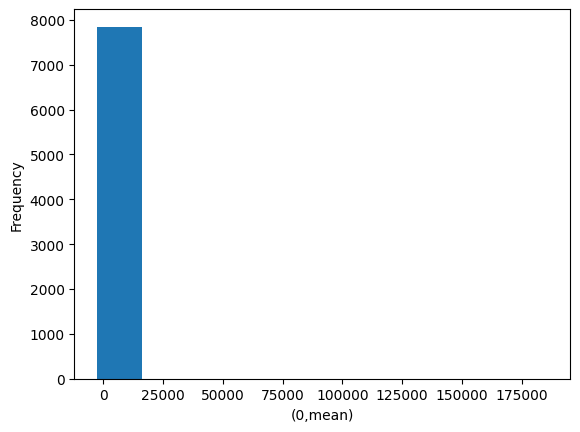

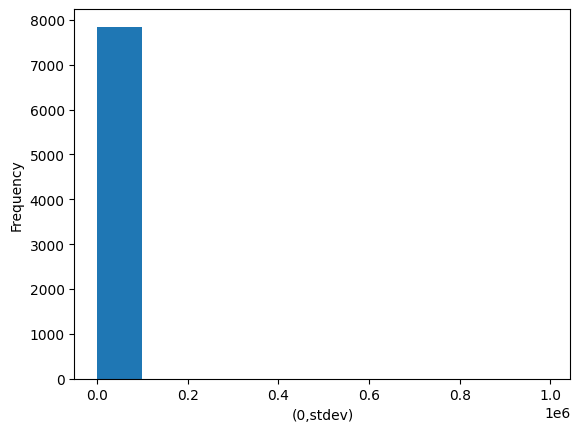

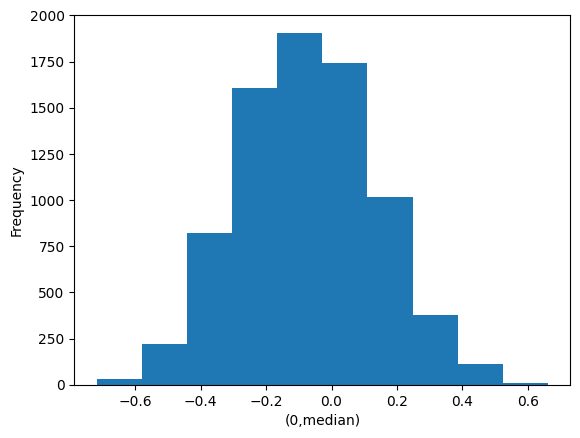

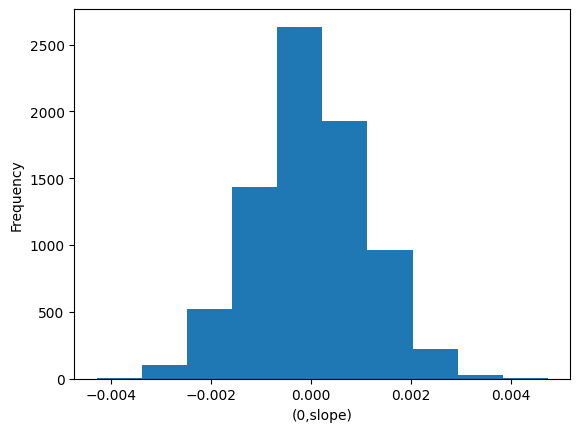

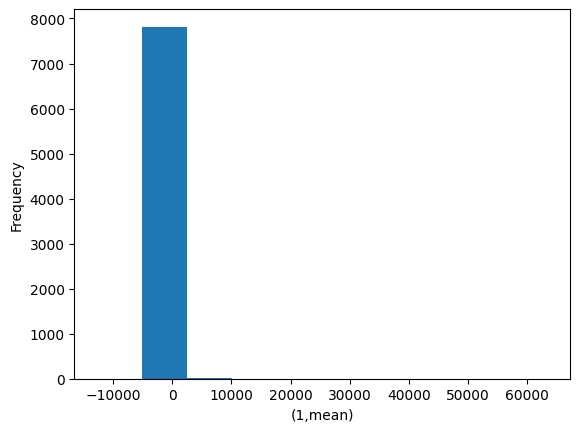

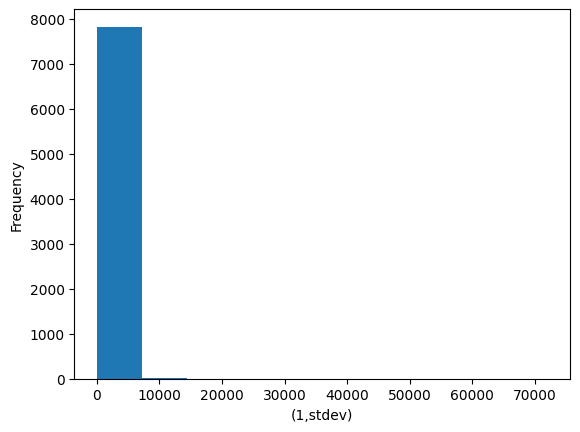

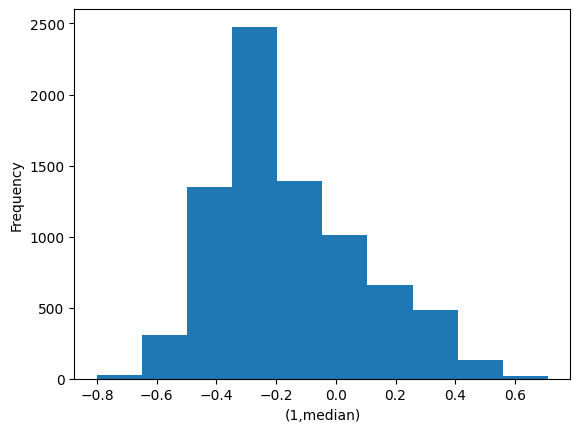

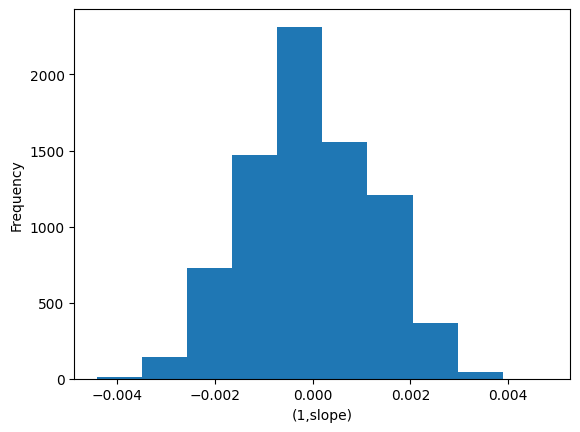

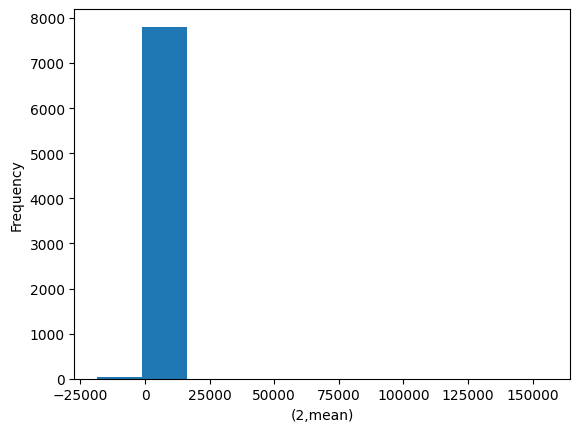

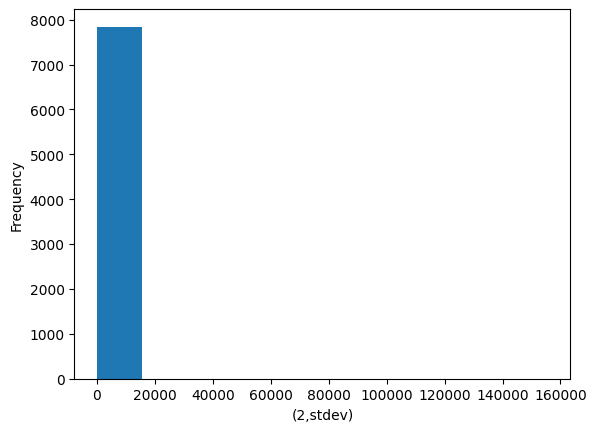

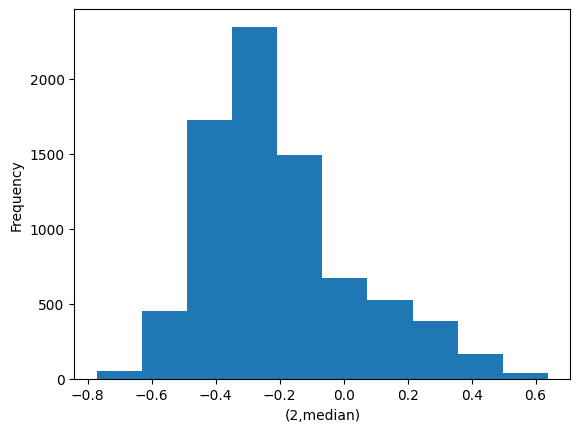

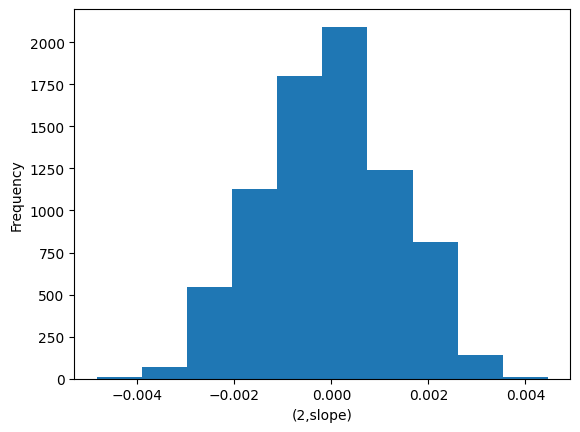

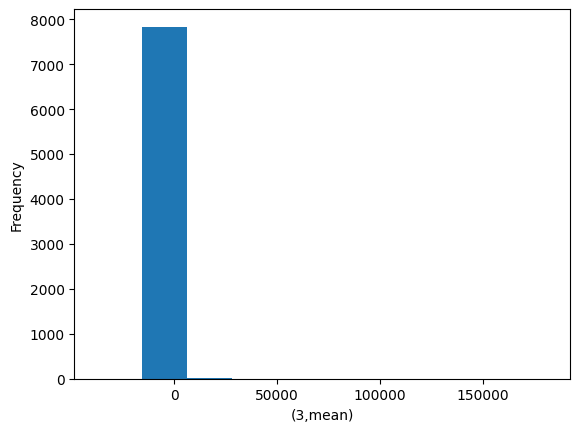

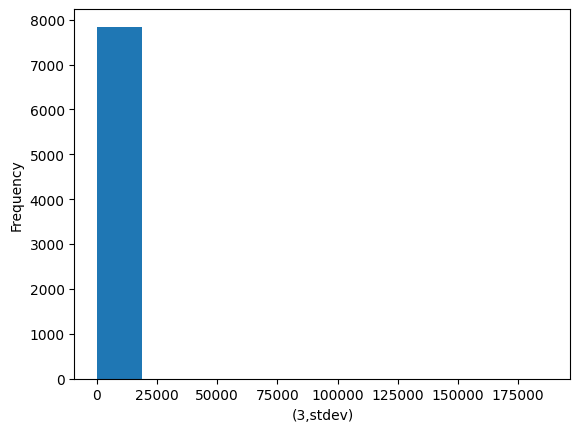

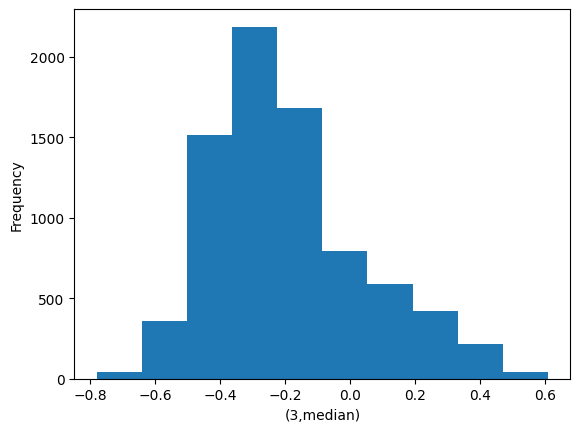

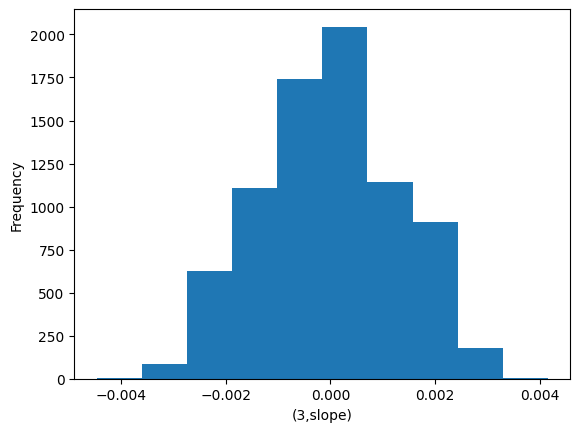

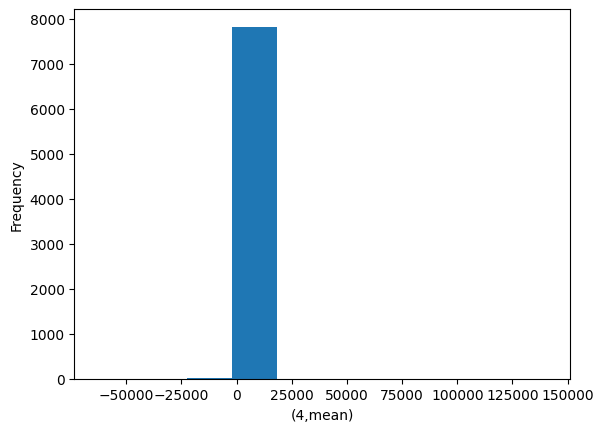

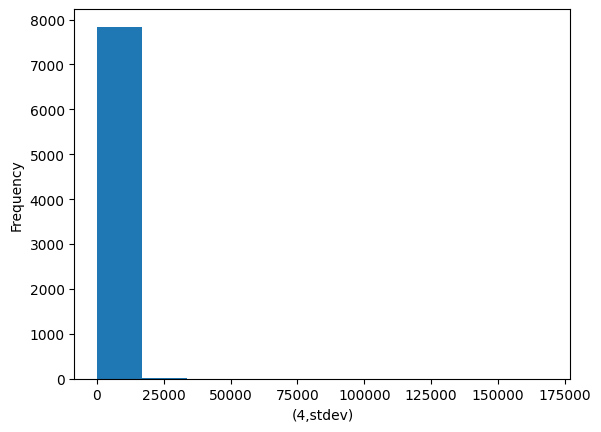

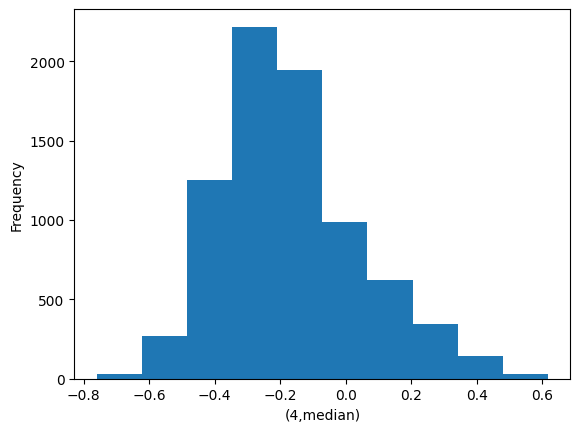

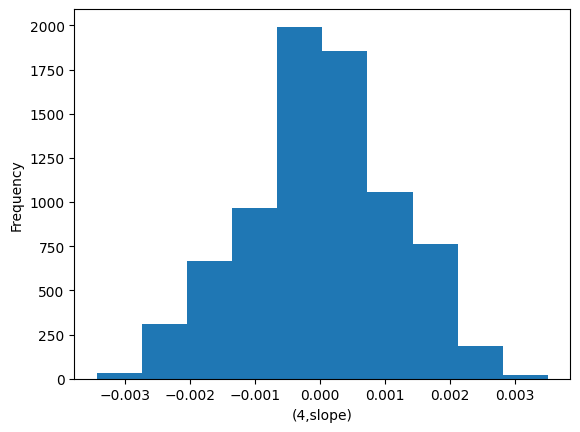

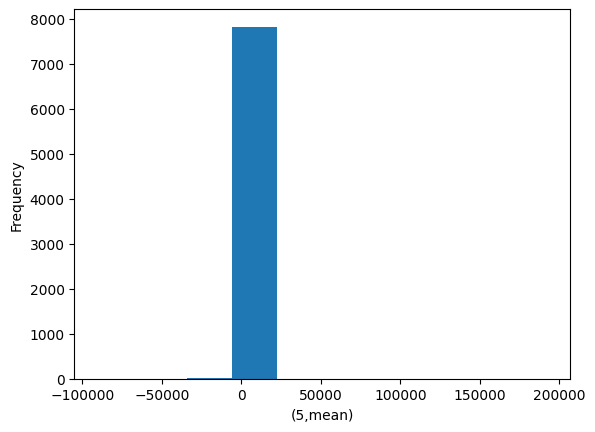

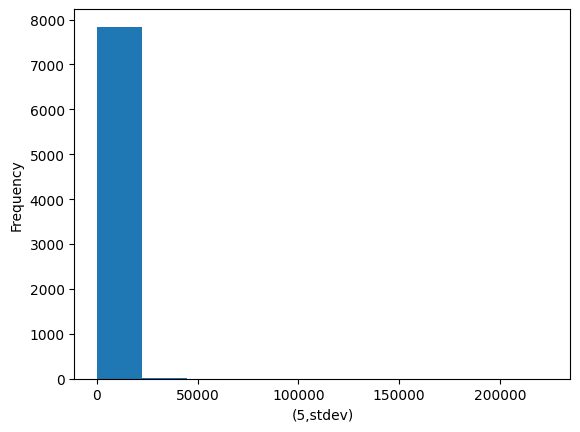

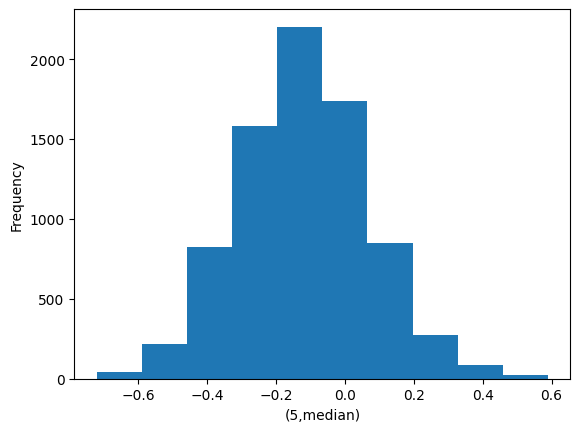

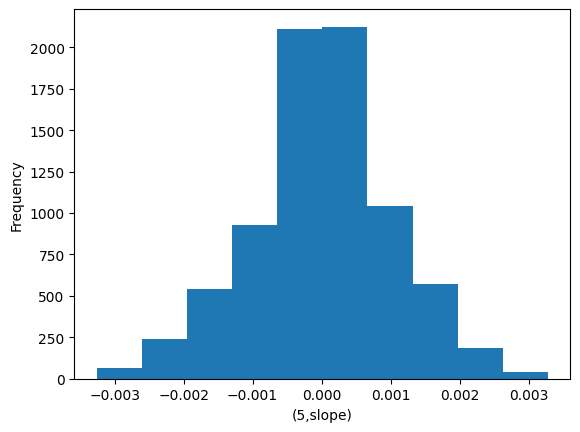

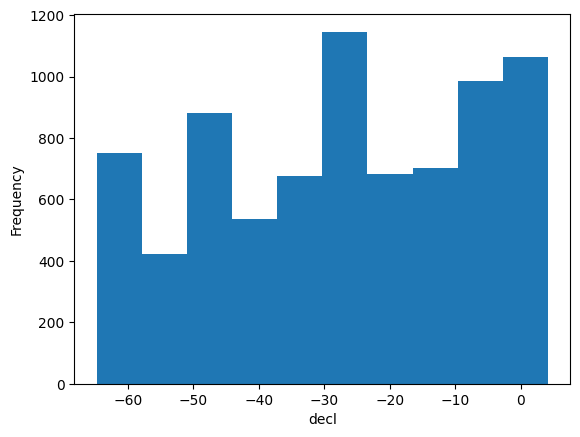

In [254]:
for i in allfeatures.columns:
  pl.figure()
  pl.hist(allfeatures[i])
  pl.xlabel(i)
  pl.ylabel('Frequency')

**Figure 4:** The distribution of the median standardized flux for 5 passbands is shown in this figure, illustrating the frequency with which various median flux values appear in the dataset. The median flux values are shown on the x-axis, while the frequency of occurrences is shown on the y-axis.

# TASK III : Gaussian Processes

Take the time series and fit them with GPs.
- use the george package goerge (see class demo https://github.com/fedhere/MLTSA_FBianco/blob/main/CodeExamples/GP_examples.ipynb)

- make sure you use the standardized time series : before you fit the GP to it each time series shoud be made to be mean 0 and standard deviation 1 (note - mean across all time stamps! not across all lightcurves). YOu can just do it by hand as lc /= lc.mean() or you can use `sklearn.preprocessing.StandardScaler`

- make sure you process the uncertainty as well as the data in the standardization! (divide by the same constant the lighcruve fluxes and its uncertaities)

- choose an appropriate kernel (e.g. the composite one we use in class that enables periodicity as well as stockastic variations)

- take a subset of the time series, ~10, making sure that they are of different types: the type is mapped to the metadata `target` variable

- fit the GP kernerl to each time series band by band

- collect the best fit parameters and describe their variance (across the 10 time series) `gp.get_parameter_vector()` - can all the time series be fit with the same kernel parameters? how would you initialize the fit for the whole ensamble?



In [255]:
# standardizing flux error
lcvs['error_standardized'] = lcvs.groupby(['object_id', 'passband'])['flux_err'].transform(lambda x: (x - x.mean()) / x.std())
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected,flux_standardized,error_standardized
0,615,59750.4229,2,-544.810303,3.622952,1,-0.902317,0.418659
1,615,59750.4306,1,-816.434326,5.553370,1,-0.715759,0.449062
2,615,59750.4383,3,-471.385529,3.801213,1,-1.044293,1.327275
3,615,59750.4450,4,-388.984985,11.395031,1,-1.141283,6.976464
4,615,59752.4070,2,-681.858887,4.041204,1,-1.203442,1.140287


In [256]:
import pandas as pd
import pylab as pl
%pylab inline

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, ExpSineSquared


Populating the interactive namespace from numpy and matplotlib


In [257]:
!pip install george

In [258]:
import george
from george import kernels

In [259]:
# example code from Bianco in Slack 3/11/2025 for the last step (i.e. last bullet point in Task III)
"""
gp = george.GP(kernel)
gp.compute(t, yerr) # this is the uncertainty! y_err, which in our made up data is =y
gp.predict(y, t_pred, return_var=True)

Then to extract the parameter for the lightcurve (which had values stored in t, y, yerr for time, flux and flux error respectively) you can get the paraameters

gp.get_parameter_vector()

Each lightcurve will return the best value for the parameters.
The last step of the homework is to look at the values of the parameters across the set of lightcurves: for N lightcurves you will have N values for each parameter that was fit to each lightcurve independently.


Which brings me to the point I wanted to make in class if I had not run out of time:
if we wanted to learn some physics, now we are in trouble: with the parameters fit individually to each lightcurve we are effectively saying “each lightcurve is its own little snowflake”,
but really we would like to be able to say “when a star explodes, the light evolves in a way that I can predict because I understand how the physics work”…
So one solution is to fit each lightcurve individually (as you did) and then look at the distribution of those values to identify the “best values” that “globally” describe a family of lightcurve.

how much variance is there in the parameters? what would you use as a representative value for the whole dataset for each parameter?
can all the time series be fit with the same kernel parameters? how would you initialize the fit for the whole ensamble?

"""

'\ngp = george.GP(kernel)\ngp.compute(t, yerr) # this is the uncertainty! y_err, which in our made up data is =y\ngp.predict(y, t_pred, return_var=True)\n\nThen to extract the parameter for the lightcurve (which had values stored in t, y, yerr for time, flux and flux error respectively) you can get the paraameters\n\ngp.get_parameter_vector()\n\nEach lightcurve will return the best value for the parameters.\nThe last step of the homework is to look at the values of the parameters across the set of lightcurves: for N lightcurves you will have N values for each parameter that was fit to each lightcurve independently.\n\n\nWhich brings me to the point I wanted to make in class if I had not run out of time:\nif we wanted to learn some physics, now we are in trouble: with the parameters fit individually to each lightcurve we are effectively saying “each lightcurve is its own little snowflake”,\nbut really we would like to be able to say “when a star explodes, the light evolves in a way that

In [260]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected,flux_standardized,error_standardized
0,615,59750.4229,2,-544.810303,3.622952,1,-0.902317,0.418659
1,615,59750.4306,1,-816.434326,5.553370,1,-0.715759,0.449062
2,615,59750.4383,3,-471.385529,3.801213,1,-1.044293,1.327275
3,615,59750.4450,4,-388.984985,11.395031,1,-1.141283,6.976464
4,615,59752.4070,2,-681.858887,4.041204,1,-1.203442,1.140287


In [261]:
"""
Cannot directly combine kernel from sklearn to george together, but am worried about not being able to include WhiteKernel
(supposed to have stochasticity)
ChatGPT's way of having a workaround to this:

from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, Cosine
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np

# Example data
x = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.sin(x).ravel() + 0.1 * np.random.randn(100)  # Periodic data with noise

# Fit a GP with WhiteKernel in sklearn
kernel = ConstantKernel(1.0) * Cosine(1.0) + WhiteKernel(noise_level=0.1)
gp_sklearn = GaussianProcessRegressor(kernel=kernel).fit(x, y)

# Extract estimated noise variance
estimated_noise = gp_sklearn.kernel_.k2.noise_level

import george
from george import kernels

# Define george kernel (without WhiteKernel)
kernel = np.var(y) * kernels.CosineKernel(1)

# Create GP model and include noise via `yerr`
gp = george.GP(kernel)
gp.compute(x.ravel(), yerr=np.sqrt(estimated_noise))

 ***** ASK BIANCO ABOUT THIS! *****
"""

"\nCannot directly combine kernel from sklearn to george together, but am worried about not being able to include WhiteKernel \n(supposed to have stochasticity)\nChatGPT's way of having a workaround to this:\n\nfrom sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, Cosine\nfrom sklearn.gaussian_process import GaussianProcessRegressor\nimport numpy as np\n\n# Example data\nx = np.linspace(0, 10, 100).reshape(-1, 1)\ny = np.sin(x).ravel() + 0.1 * np.random.randn(100)  # Periodic data with noise\n\n# Fit a GP with WhiteKernel in sklearn\nkernel = ConstantKernel(1.0) * Cosine(1.0) + WhiteKernel(noise_level=0.1)\ngp_sklearn = GaussianProcessRegressor(kernel=kernel).fit(x, y)\n\n# Extract estimated noise variance\nestimated_noise = gp_sklearn.kernel_.k2.noise_level\n\nimport george\nfrom george import kernels\n\n# Define george kernel (without WhiteKernel)\nkernel = np.var(y) * kernels.CosineKernel(1)\n\n# Create GP model and include noise via `yerr`\ngp = george.GP(kernel

In [262]:
# from github.com/fedhere/MLTSA_FBianco/blob/main/CodeExamples/GP_examples.ipynb
# testing code
"""
Testing a george run on object_id = 615
"""
"""
# print(lcvs['object_id'].dtype)

flux_stand_615 = lcvs.loc[lcvs['object_id'] == 615, 'flux_standardized'].values # y
mjd_615 = lcvs.loc[lcvs['object_id'] == 615, 'mjd'].values # t
flux_err_stand_615 = lcvs.loc[lcvs['object_id'] == 615, 'error_standardized'].values # yerr

flux_err_stand_615_pos = np.abs(flux_err_stand_615) # pos error for all
"""
"""
# ----------- evenly sampled time axis -----------

min_mjd = lcvs['mjd'].min() # mjd is our unit of time here
max_mjd = lcvs['mjd'].max()
# print(min_mjd,max_mjd)
mjd_pred = np.atleast_2d(np.linspace(min_mjd, max_mjd, 1000)).T

# ----------- kernel stuff -----------

# np.var(y) is a single value, not an array
# want to introduce stochasticity --> WhiteKernel
# but, george does not have a direct thing to do WhiteKernel
# want to introduce perodicity --> CosineKernel

kernel = np.var(flux_stand_615) * kernels.Product(kernels.ExpSquaredKernel(0.5),
                                     kernels.CosineKernel(1))

# kernel = np.var(flux_stand_615) * kernels.CosineKernel(1)

# CANNOT RUN ON ENTIRE FLUX ARRAY, MUST SEPARATE INTO 10 GROUPS BY OBJECT ID

gp = george.GP(kernel)
gp.compute(mjd_615 , flux_err_stand_615)


pred, pred_var = gp.predict(flux_stand_615, mjd_pred, return_var=True)

pl.fill_between(mjd_pred.ravel(), pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(mjd_pred.ravel(), pred, "k", lw=1.5, alpha=0.5)

pl.errorbar(mjd_615, flux_stand_615, yerr=flux_err_stand_615_pos, fmt=".k", capsize=0)
pl.xlabel("mjd")
pl.ylabel("standardized flux");
pl.title("object 615");

print("parameters {:.2f} {:.2f}".format(*gp.get_parameter_vector()))
print("ln-likelihood: {0:.2f}".format(gp.log_likelihood(flux_stand_615)))
"""

'\n# ----------- evenly sampled time axis -----------\n\nmin_mjd = lcvs[\'mjd\'].min() # mjd is our unit of time here\nmax_mjd = lcvs[\'mjd\'].max()\n# print(min_mjd,max_mjd)\nmjd_pred = np.atleast_2d(np.linspace(min_mjd, max_mjd, 1000)).T\n\n# ----------- kernel stuff -----------\n\n# np.var(y) is a single value, not an array\n# want to introduce stochasticity --> WhiteKernel \n# but, george does not have a direct thing to do WhiteKernel \n# want to introduce perodicity --> CosineKernel\n\nkernel = np.var(flux_stand_615) * kernels.Product(kernels.ExpSquaredKernel(0.5),\n                                     kernels.CosineKernel(1))\n\n# kernel = np.var(flux_stand_615) * kernels.CosineKernel(1)\n\n# CANNOT RUN ON ENTIRE FLUX ARRAY, MUST SEPARATE INTO 10 GROUPS BY OBJECT ID\n\ngp = george.GP(kernel)\ngp.compute(mjd_615 , flux_err_stand_615)\n\n\npred, pred_var = gp.predict(flux_stand_615, mjd_pred, return_var=True)\n\npl.fill_between(mjd_pred.ravel(), pred - np.sqrt(pred_var), pred + np.

In [263]:
"""
y = flux_stand_615

from scipy.optimize import minimize
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)
"""

'\ny = flux_stand_615\n\nfrom scipy.optimize import minimize\ndef neg_ln_like(p):\n    gp.set_parameter_vector(p)\n    return -gp.log_likelihood(y)\n\ndef grad_neg_ln_like(p):\n    gp.set_parameter_vector(p)\n    return -gp.grad_log_likelihood(y)\n'

In [264]:
# ----------------------------------
# additional code from example
"""
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)
gp.set_parameter_vector(result.x)

pred, pred_var = gp.predict(flux_stand_615, mjd_pred, return_var=True)
pl.figure()
pl.fill_between(mjd_pred[:,0], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(mjd_pred[:,0], pred, "k", lw=1.5, alpha=0.5)
pl.errorbar(mjd_615, flux_stand_615, yerr=flux_err_stand_615_pos, fmt=".k", capsize=0)
pl.xlabel("mjd")
pl.ylabel("standardized flux");
pl.title("object 615");

print("Optimized parameters {:.2f} {:.2f}".format(*gp.get_parameter_vector()))
print("Optimized ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

gp.compute(mjd_615, 0.1*np.abs(flux_stand_615))

pred, pred_var = gp.predict(flux_stand_615, mjd_pred, return_var=True)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
#print(result)
gp.set_parameter_vector(result.x)

pred, pred_var = gp.predict(flux_stand_615, mjd_pred, return_var=True)
pl.figure()
pl.fill_between(mjd_pred[:,0], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(mjd_pred[:,0], pred, "k", lw=1.5, alpha=0.5)
pl.errorbar(mjd_615, flux_stand_615, yerr=flux_err_stand_615_pos, fmt=".k", capsize=0)
pl.xlabel("mjd")
pl.ylabel("standardized flux");
pl.title("object 615");

print("Optimized parameters {:.2f} {:.2f}".format(*gp.get_parameter_vector()))
print("Optimized ln-likelihood: {0:.2f}".format(gp.log_likelihood(flux_stand_615)))
"""

'\nresult = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)\nprint(result)\ngp.set_parameter_vector(result.x)\n\npred, pred_var = gp.predict(flux_stand_615, mjd_pred, return_var=True)\npl.figure()\npl.fill_between(mjd_pred[:,0], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),\n                color="k", alpha=0.2)\npl.plot(mjd_pred[:,0], pred, "k", lw=1.5, alpha=0.5)\npl.errorbar(mjd_615, flux_stand_615, yerr=flux_err_stand_615_pos, fmt=".k", capsize=0)\npl.xlabel("mjd")\npl.ylabel("standardized flux");\npl.title("object 615");\n\nprint("Optimized parameters {:.2f} {:.2f}".format(*gp.get_parameter_vector()))\nprint("Optimized ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))\n\ngp.compute(mjd_615, 0.1*np.abs(flux_stand_615))\n\npred, pred_var = gp.predict(flux_stand_615, mjd_pred, return_var=True)\n\nresult = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)\n#print(result)\ngp.set_parameter_vector(result.x)\n\npred, pred_var = gp.pre

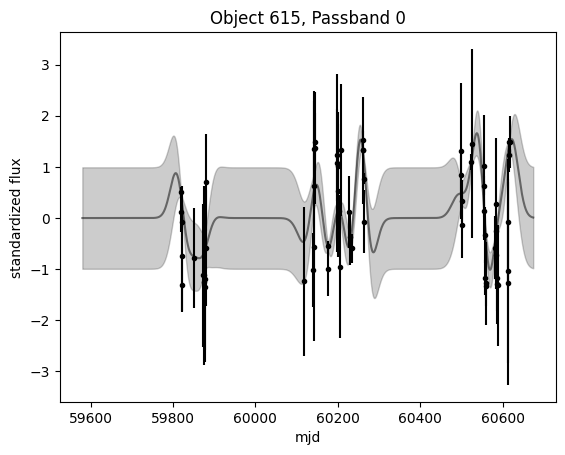

parameters -0.02 5.70
ln-likelihood: -104.87


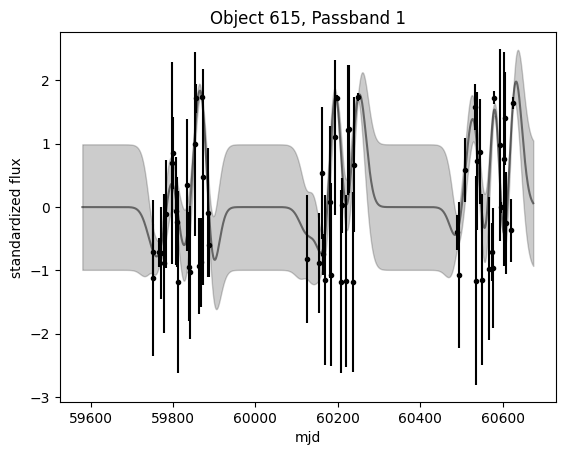

parameters -0.02 5.70
ln-likelihood: -125.21


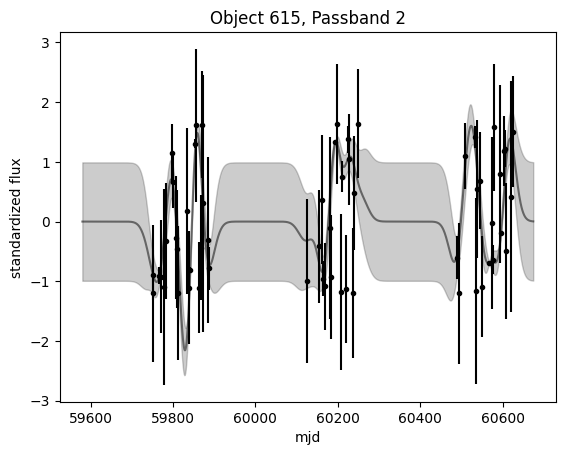

parameters -0.02 5.70
ln-likelihood: -99.35


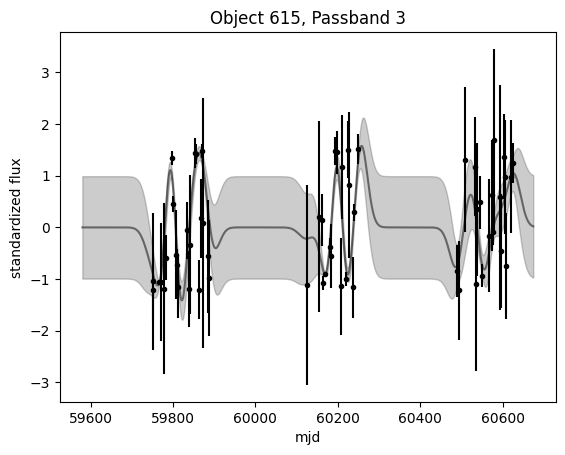

parameters -0.02 5.70
ln-likelihood: -113.38


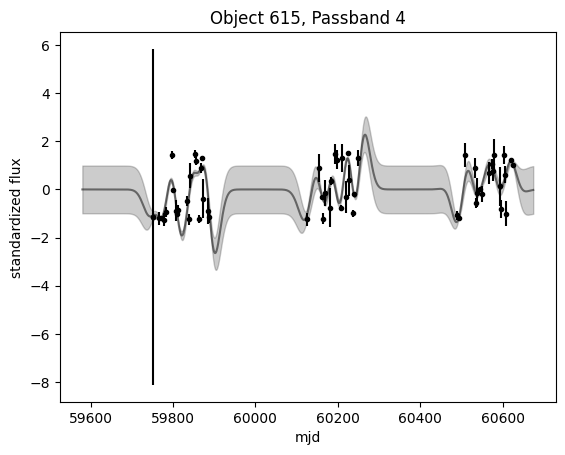

parameters -0.02 5.70
ln-likelihood: -308.35


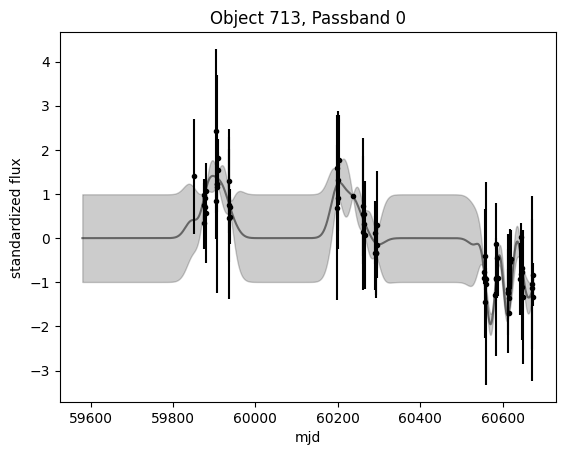

parameters -0.01 5.70
ln-likelihood: -100.98


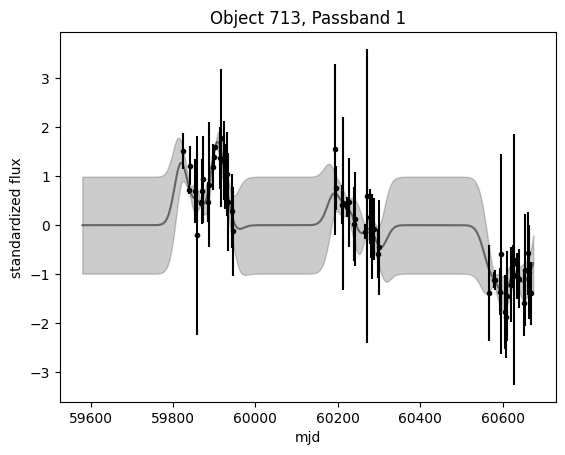

parameters -0.02 5.70
ln-likelihood: -56.54


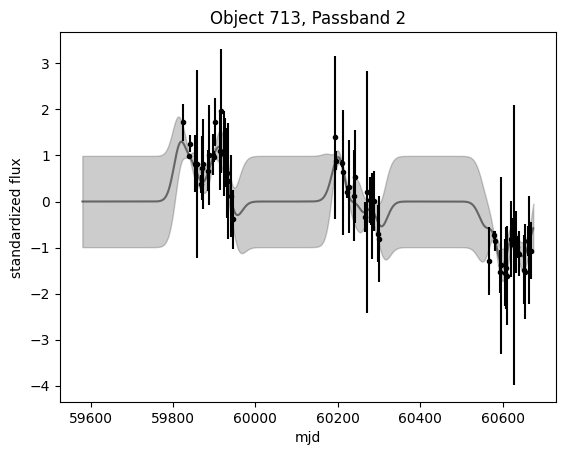

parameters -0.02 5.70
ln-likelihood: -57.71


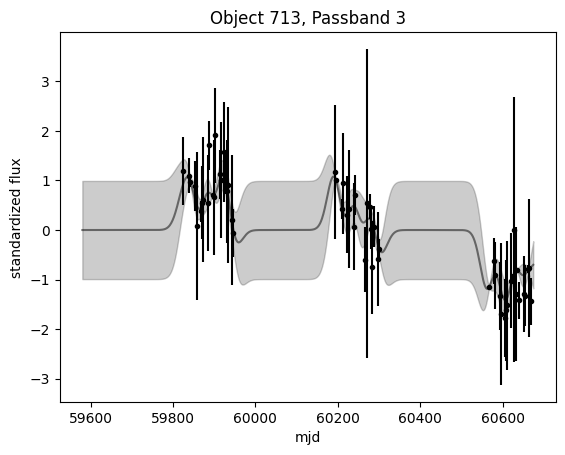

parameters -0.02 5.70
ln-likelihood: -62.77


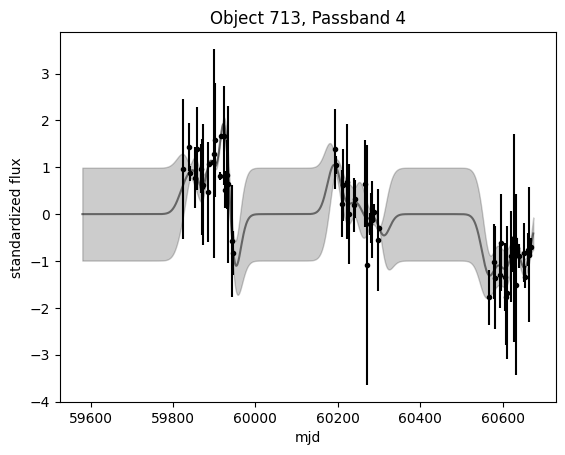

parameters -0.02 5.70
ln-likelihood: -97.25


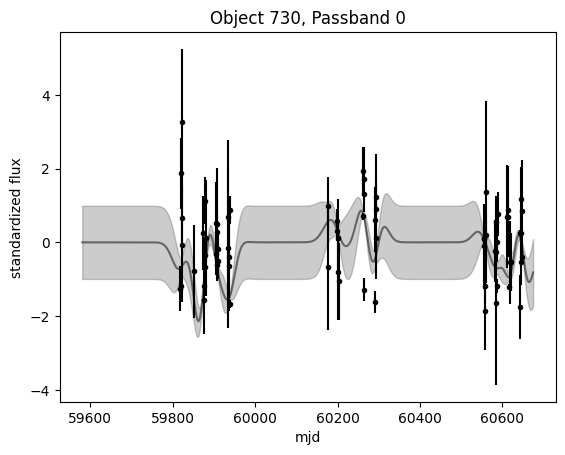

parameters -0.01 5.70
ln-likelihood: -198.82


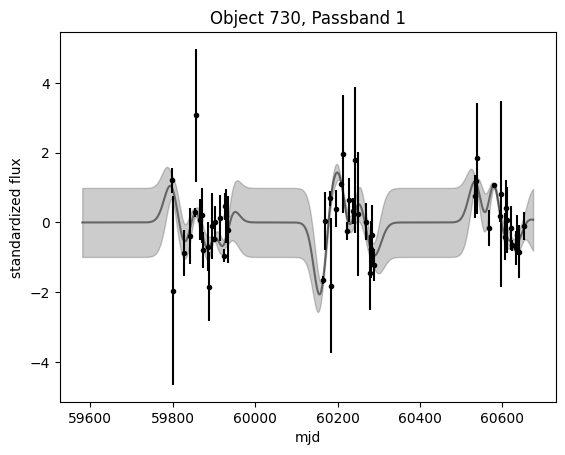

parameters -0.02 5.70
ln-likelihood: -74.99


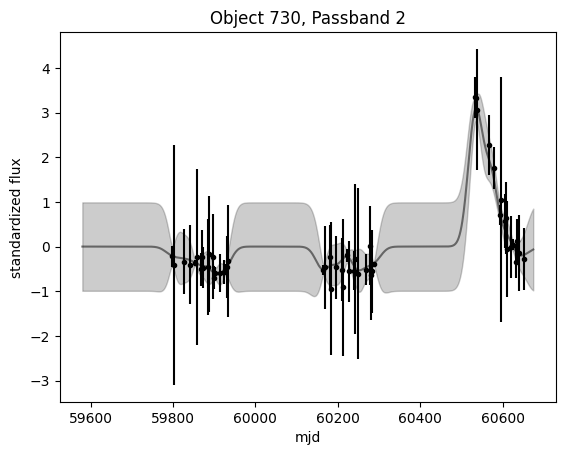

parameters -0.02 5.70
ln-likelihood: -54.94


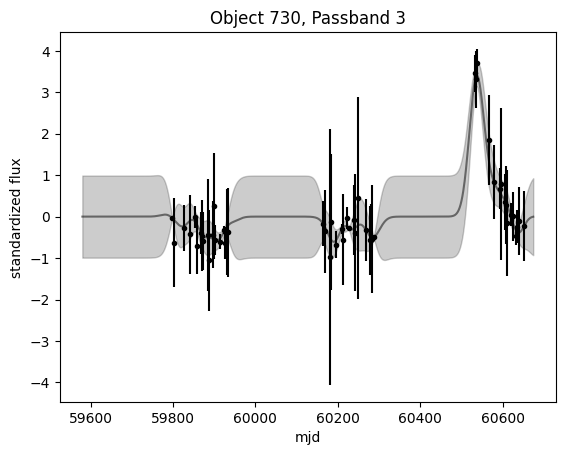

parameters -0.02 5.70
ln-likelihood: -56.80


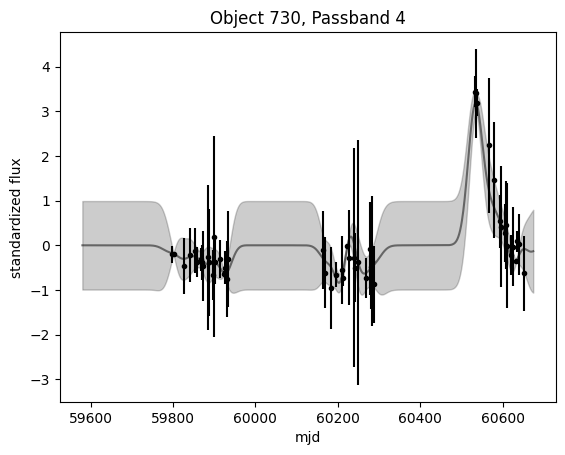

parameters -0.02 5.70
ln-likelihood: -55.67


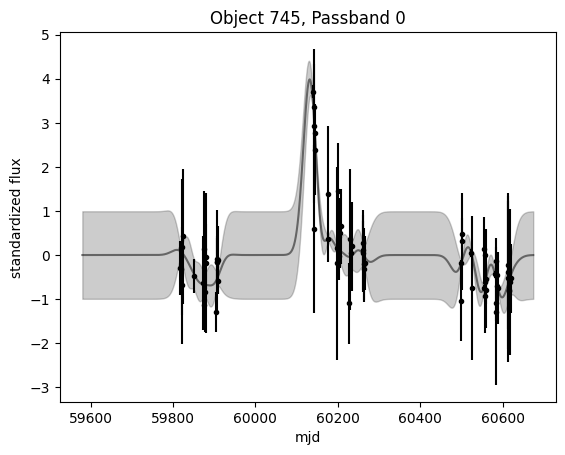

parameters -0.01 5.70
ln-likelihood: -87.38


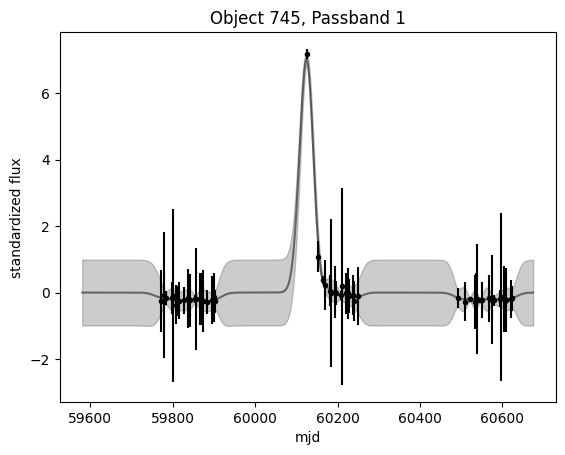

parameters -0.02 5.70
ln-likelihood: -74.99


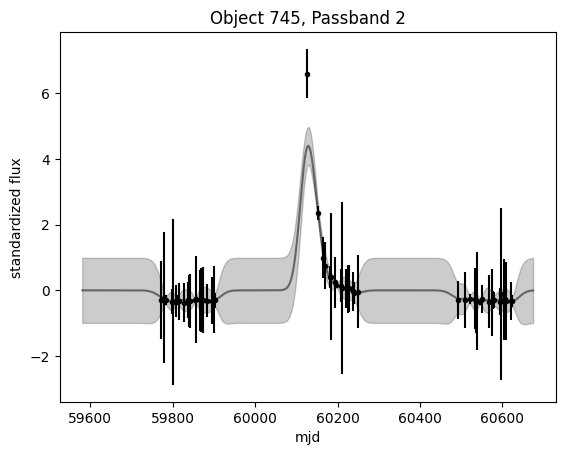

parameters -0.02 5.70
ln-likelihood: -65.33


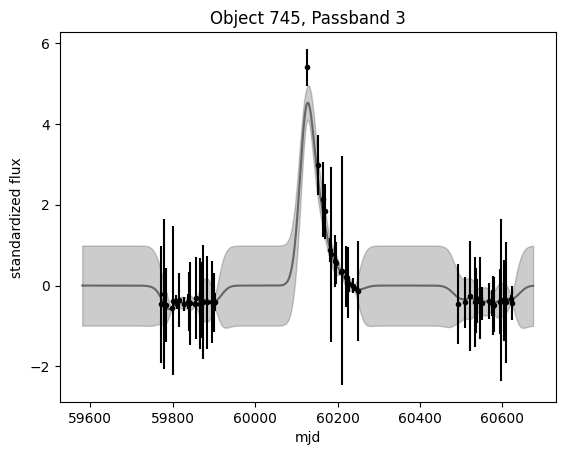

parameters -0.02 5.70
ln-likelihood: -63.69


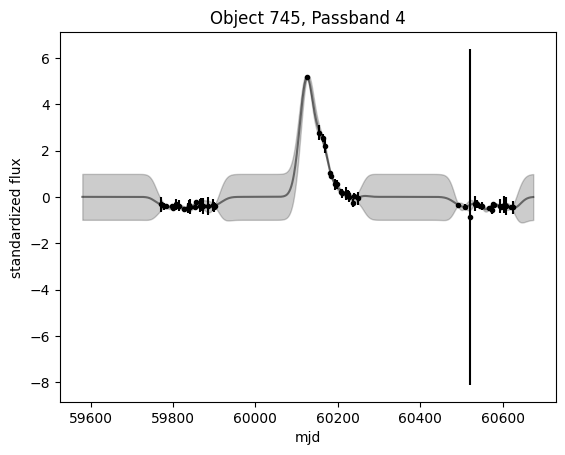

parameters -0.02 5.70
ln-likelihood: -25.68


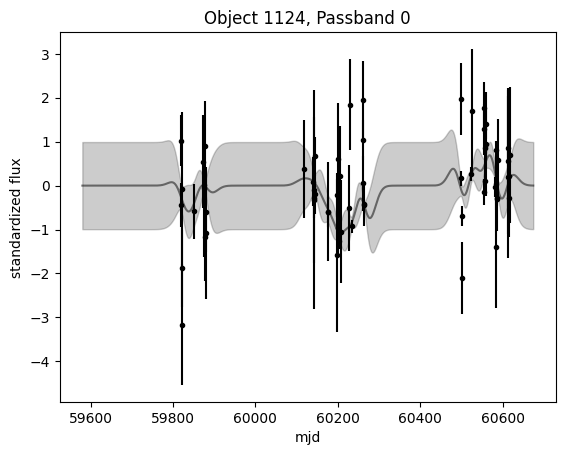

parameters -0.02 5.70
ln-likelihood: -111.27


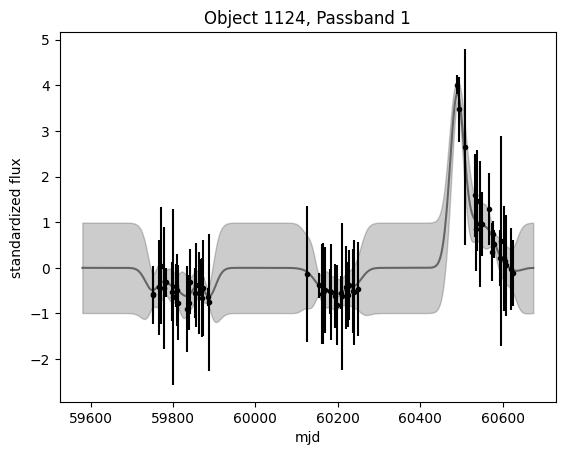

parameters -0.02 5.70
ln-likelihood: -68.91


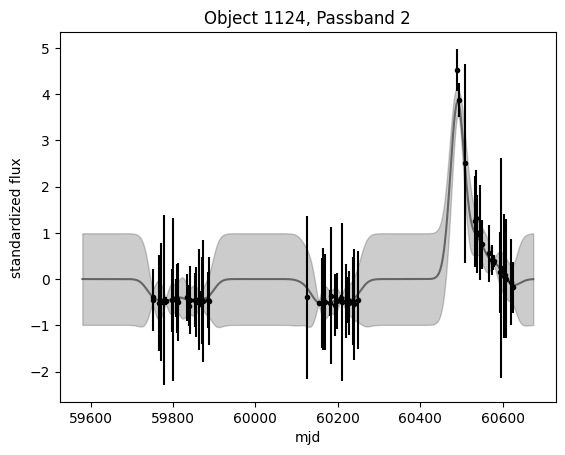

parameters -0.02 5.70
ln-likelihood: -64.91


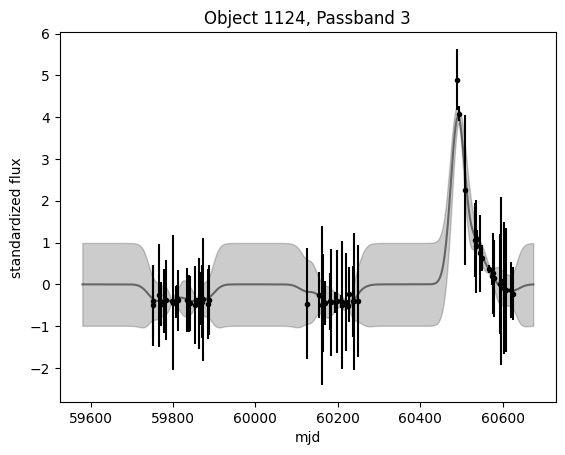

parameters -0.02 5.70
ln-likelihood: -66.31


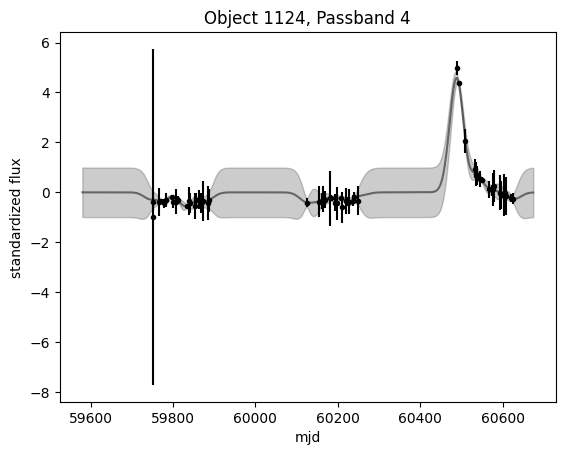

parameters -0.02 5.70
ln-likelihood: -42.66


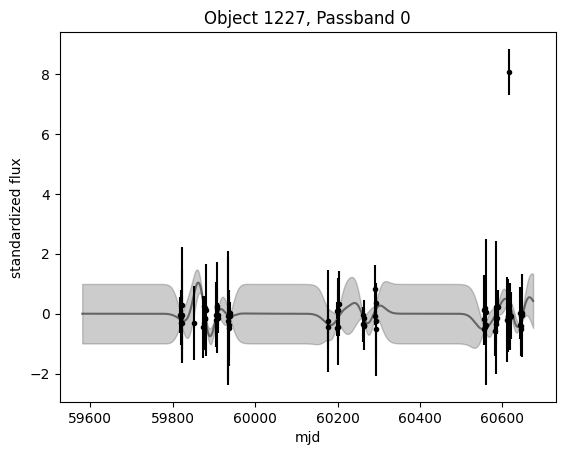

parameters -0.01 5.70
ln-likelihood: -117.19


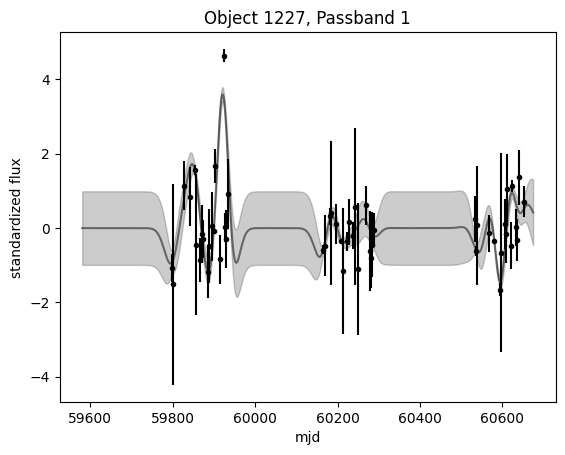

parameters -0.02 5.70
ln-likelihood: -159.09


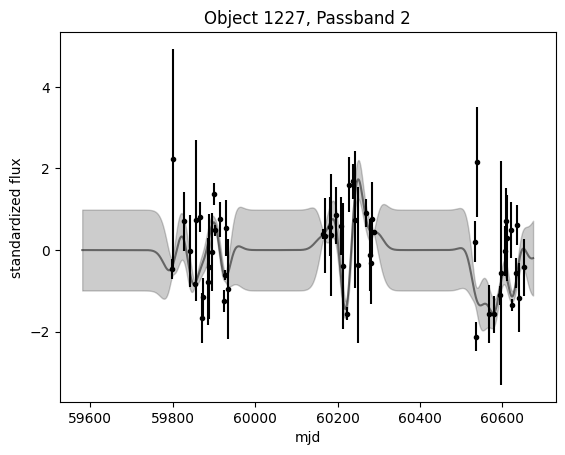

parameters -0.02 5.70
ln-likelihood: -113.34


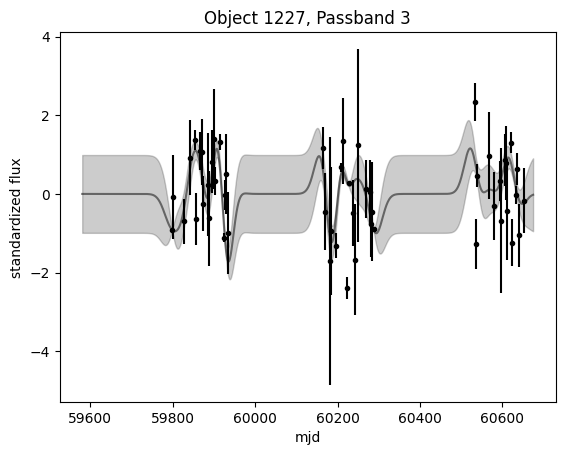

parameters -0.02 5.70
ln-likelihood: -154.25


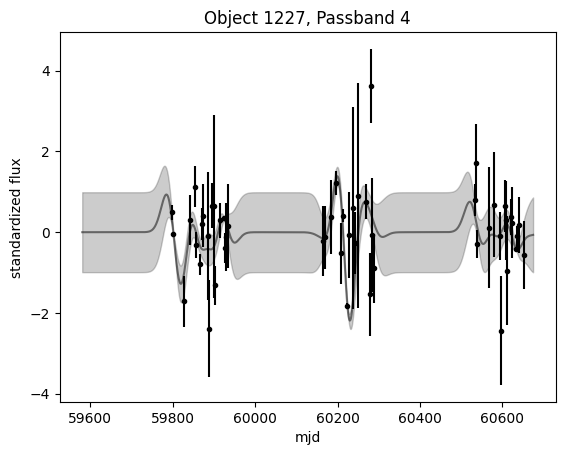

parameters -0.02 5.70
ln-likelihood: -90.54


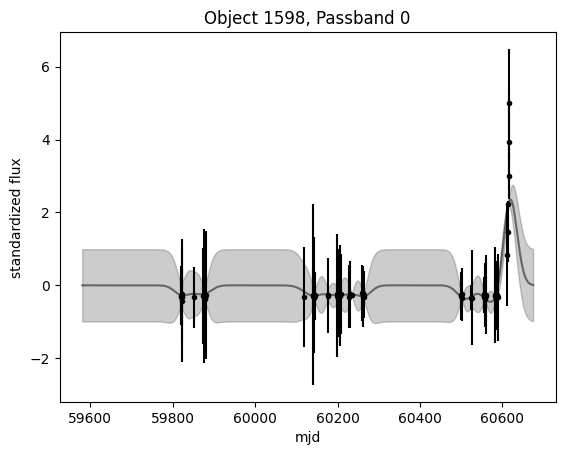

parameters -0.02 5.70
ln-likelihood: -62.24


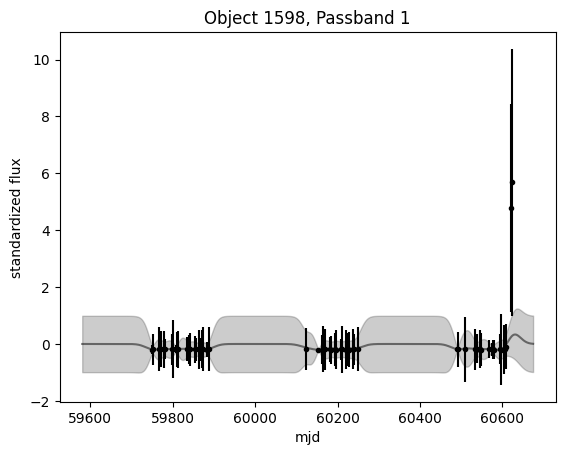

parameters -0.02 5.70
ln-likelihood: -46.24


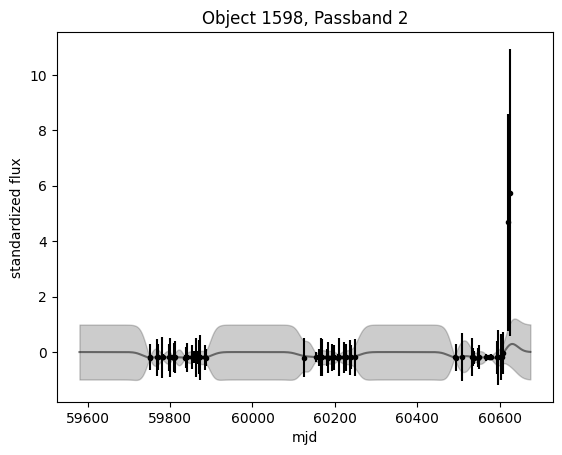

parameters -0.02 5.70
ln-likelihood: -35.77


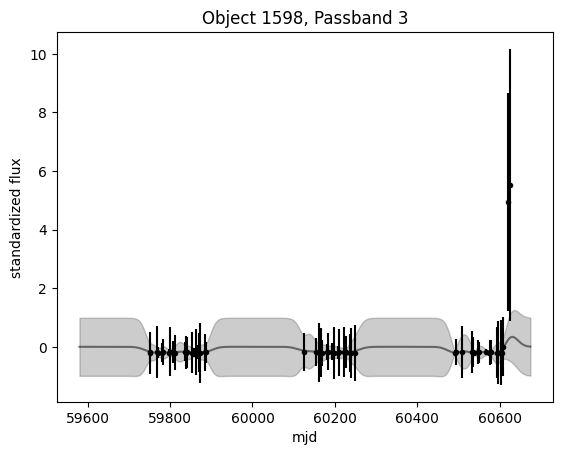

parameters -0.02 5.70
ln-likelihood: -43.22


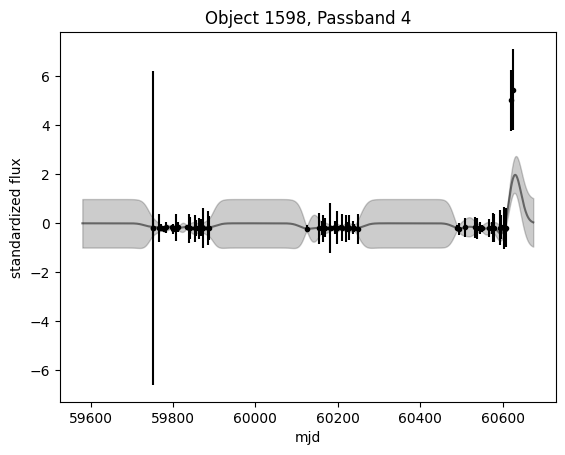

parameters -0.02 5.70
ln-likelihood: -40.49


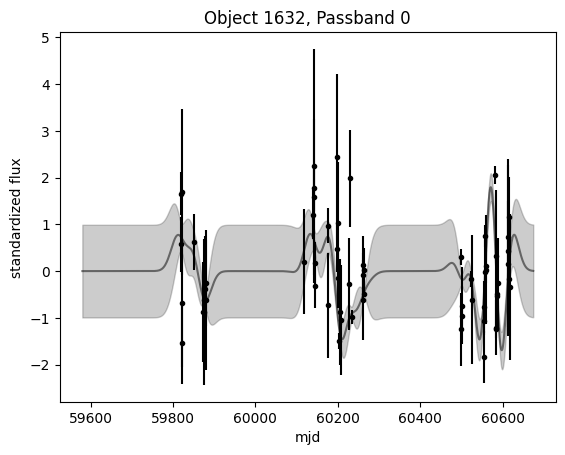

parameters -0.02 5.70
ln-likelihood: -181.68


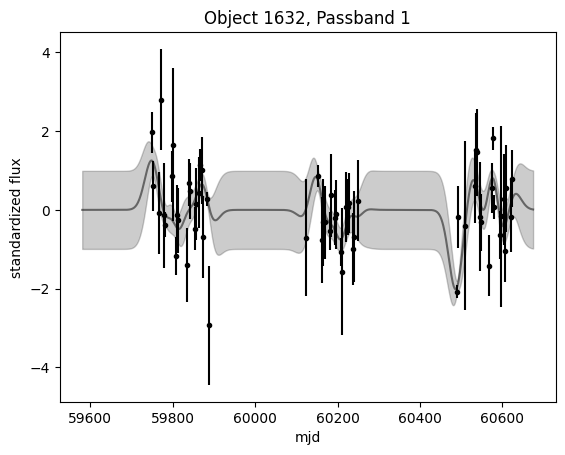

parameters -0.02 5.70
ln-likelihood: -97.90


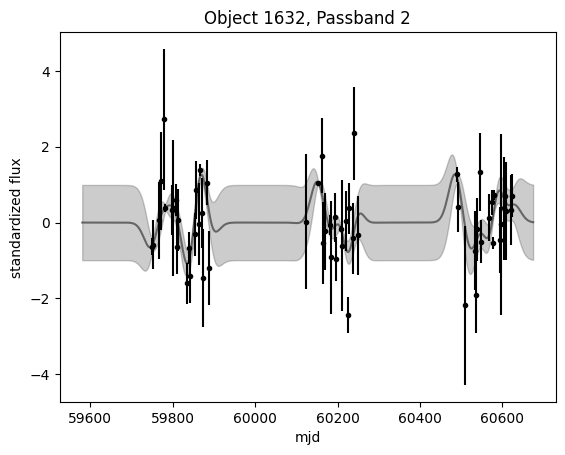

parameters -0.02 5.70
ln-likelihood: -103.09


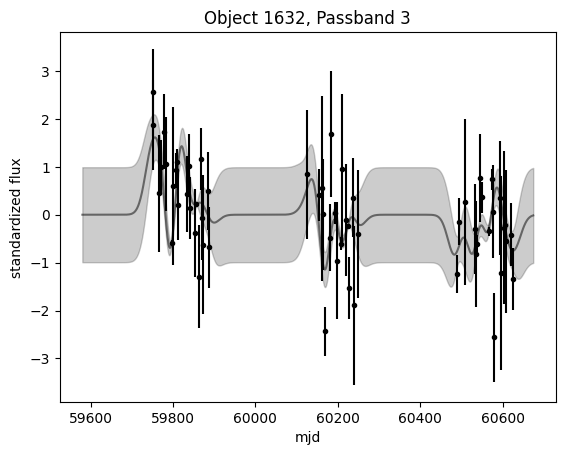

parameters -0.02 5.70
ln-likelihood: -98.68


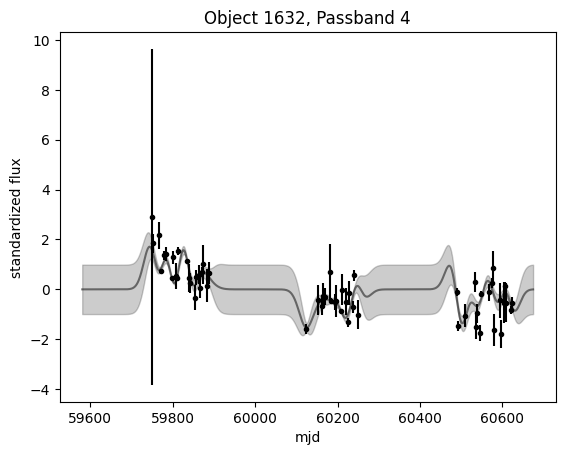

parameters -0.02 5.70
ln-likelihood: -114.69


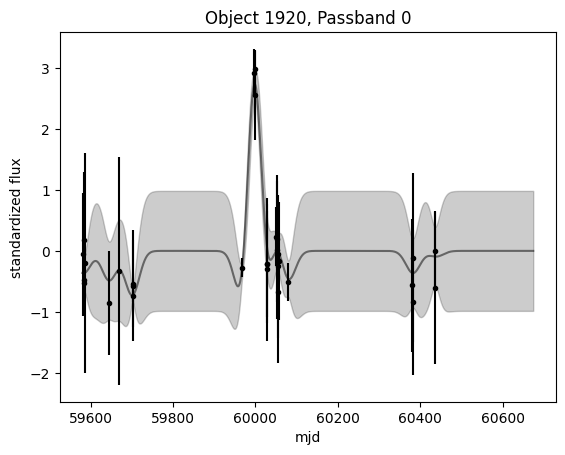

parameters -0.03 5.70
ln-likelihood: -37.40


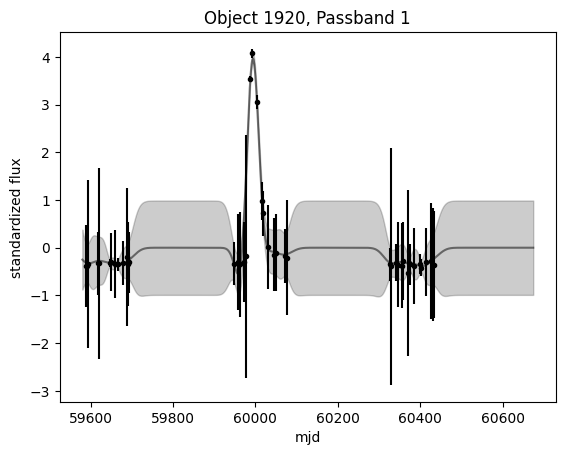

parameters -0.02 5.70
ln-likelihood: -53.28


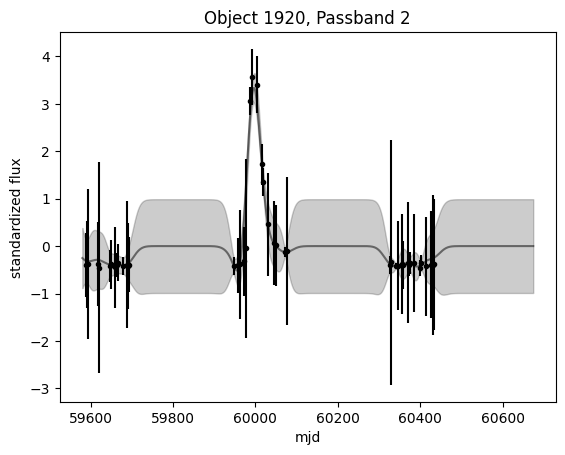

parameters -0.02 5.70
ln-likelihood: -49.71


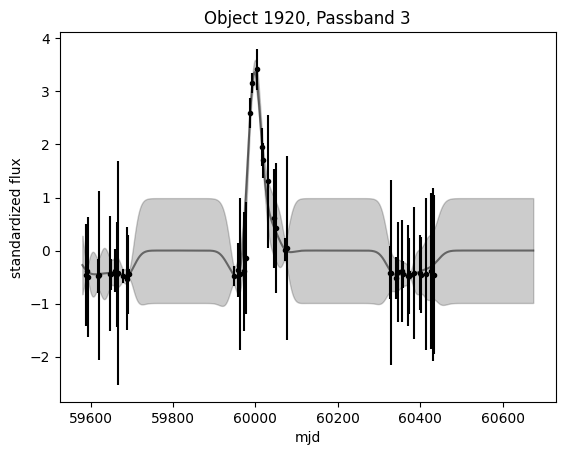

parameters -0.02 5.70
ln-likelihood: -51.77


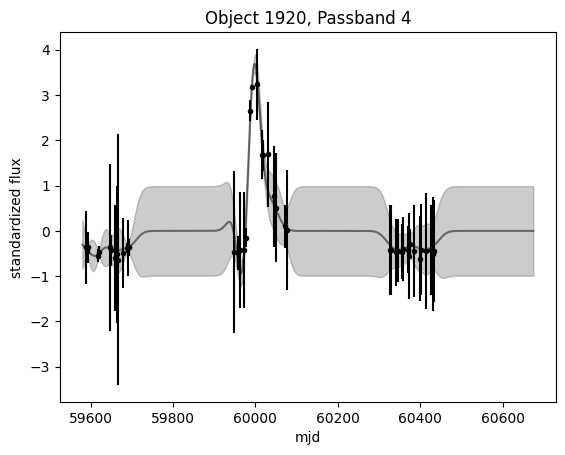

parameters -0.02 5.70
ln-likelihood: -53.18


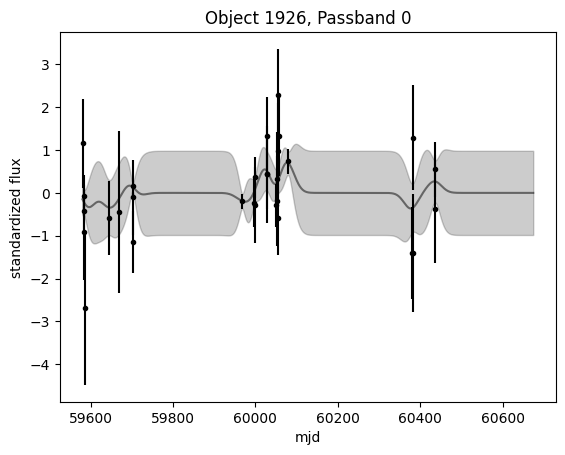

parameters -0.03 5.70
ln-likelihood: -41.85


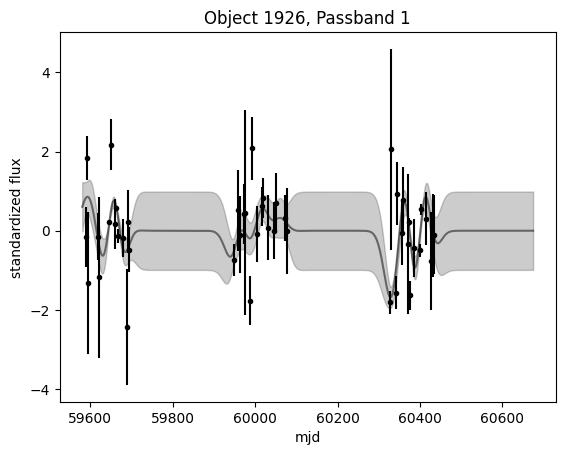

parameters -0.02 5.70
ln-likelihood: -88.58


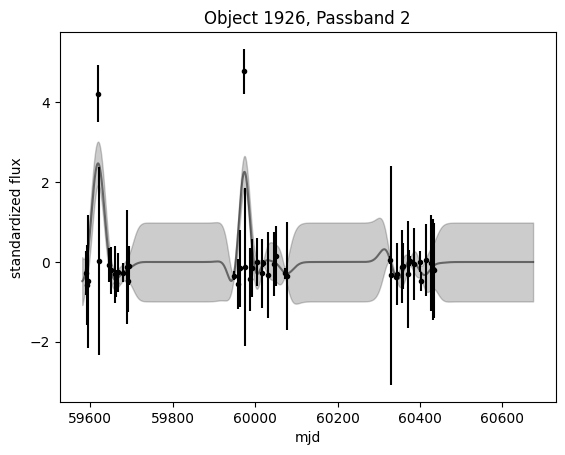

parameters -0.02 5.70
ln-likelihood: -71.45


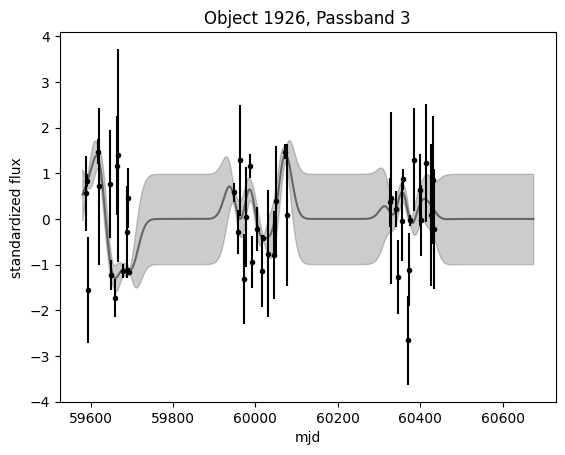

parameters -0.02 5.70
ln-likelihood: -78.95


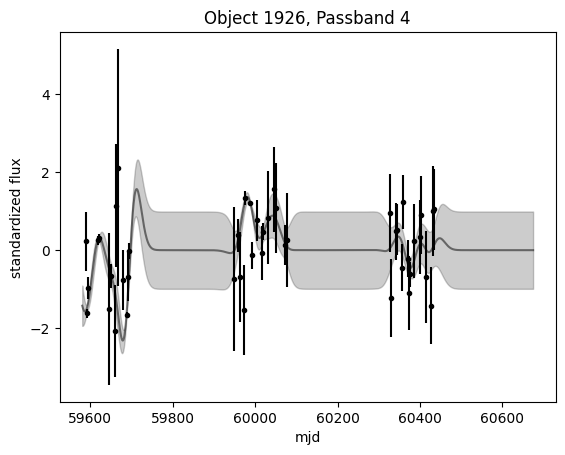

parameters -0.02 5.70
ln-likelihood: -78.53


In [265]:
# loop for all fitting
datalist = lcvs["object_id"].unique()[:10]
parameter1List = []
parameter2List = []
# print(lcvs['passband'])

for x in datalist:
  for y in range(0,5):
  # plt.plot(lcvs[lcvs["object_id"] == x]["mjd"], lcvs[lcvs["object_id"] == x]["flux"])
  # plt.xlabel('mjd (time)')
  # plt.ylabel('flux')
  # plt.title('Object {}'.format(x))
  # plt.show()
    lcvs_obj = lcvs.loc[lcvs['object_id'] == x]

    flux_stand = lcvs_obj.loc[lcvs['passband'] == y, 'flux_standardized'].values # y
    # flux_stand_real = lcvs.loc[lcvs['object_id'] == x, 'flux_standardized'].values # y
    mjd = lcvs_obj.loc[lcvs['passband'] == y, 'mjd'].values # t
    flux_err_stand = lcvs_obj.loc[lcvs['passband'] == y, 'error_standardized'].values # yerr

    flux_err_stand_pos = np.abs(flux_err_stand) # pos error for all

    # ----------- evenly sampled time axis -----------

    min_mjd = lcvs['mjd'].min() # mjd is our unit of time here
    max_mjd = lcvs['mjd'].max()
    # print(min_mjd,max_mjd)
    mjd_pred = np.atleast_2d(np.linspace(min_mjd, max_mjd, 1000)).T

    # ----------- kernel stuff -----------
    # kernel implemented here is correct, we just had to adjust the parameter values of the kernel
    # because our time series spread is very large/large numbers

    kernel = np.var(flux_stand) * kernels.Product(kernels.ExpSquaredKernel(300.0),
                                         kernels.CosineKernel(800))

    # kernel = np.var(flux_stand) * kernels.CosineKernel(100)

    gp = george.GP(kernel)
    gp.compute(mjd , flux_err_stand)

    pred, pred_var = gp.predict(flux_stand, mjd_pred, return_var=True)

    pl.fill_between(mjd_pred.ravel(), pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                    color="k", alpha=0.2)
    pl.plot(mjd_pred.ravel(), pred, "k", lw=1.5, alpha=0.5)

    pl.errorbar(mjd, flux_stand, yerr=flux_err_stand_pos, fmt=".k", capsize=0)
    pl.xlabel("mjd")
    pl.ylabel("standardized flux");
    pl.title('Object {}, Passband {}'.format(x, y));
    plt.show()

    print("parameters {:.2f} {:.2f}".format(*gp.get_parameter_vector()))
    print("ln-likelihood: {0:.2f}".format(gp.log_likelihood(flux_stand)))

    vals = gp.get_parameter_vector()

    parameter1List.append(vals[0])
    parameter2List.append(vals[1])


**Figure 5:**
The plots for each lightcurve in each passband fit using gaussian processes using the package  george. For our kernel we used the product of an exponential squared kernel with a metric of 300, and a Cosine kernel with a period of 800 days.

Variance of Parameter 1: 1.4488897576316784e-05
Mean of Parameter 1: -0.018929289521524385


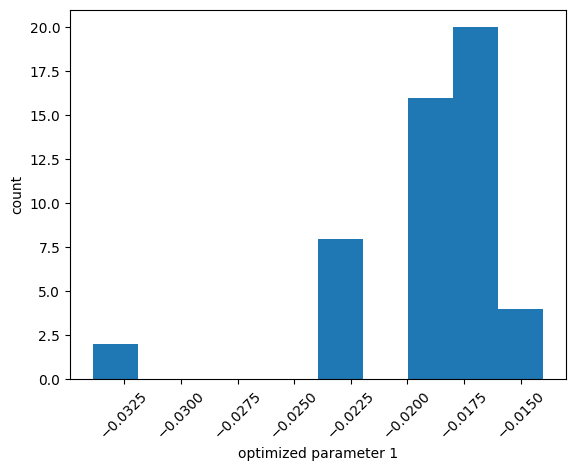

Variance of Parameter 2: 7.888609052210118e-31
Mean of Parameter 2: 5.7037824746562


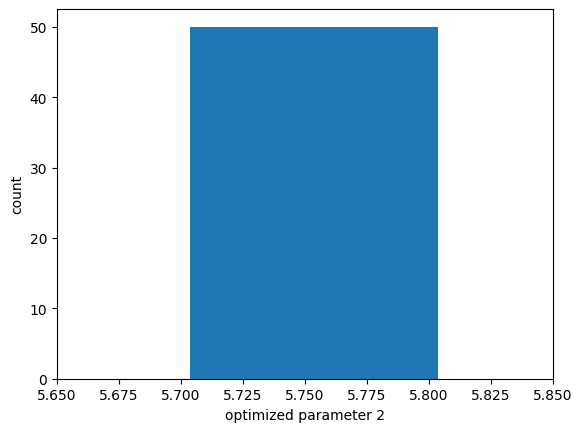

In [266]:
varParam1 = np.var(parameter1List)
print("Variance of Parameter 1: " + str(varParam1))
meanParam1 = np.mean(parameter1List)
print("Mean of Parameter 1: " + str(meanParam1))

plt.hist(parameter1List)
plt.xlabel("optimized parameter 1")
plt.xticks(rotation=45) # slightly tilts the dates so it's easier to read
plt.ylabel("count")
plt.show()

varParam2 = np.var(parameter2List)
print("Variance of Parameter 2: " + str(varParam2))
meanParam2 = np.mean(parameter2List)
print("Mean of Parameter 2: " + str(meanParam2))

plt.hist(parameter2List)
plt.xlabel("optimized parameter 2")
plt.ylabel("count")
plt.xlim(5.65, 5.85)
plt.show()

**Figure 6:**
Histograms of the optimized parameters from fitting each object's standardized lightband. A larger spread of values are seen in the resulting Parameter 1 values versus Parameter 2, where the majority of Parameter 2 values hover around its mean of 5.7.

**Answering "Can all the time series be fit with the same kernel parameters? How would you initialize the fit for the whole ensemble?"**

From getting the mean of the collected optimized parameters respectively, the best "global" value to use for Parameter 1 comes out to be -0.018, while the best "global" value to use for Parameter 2 comes out to be 5.7. It is noted that the variance of Parameter 1 (1.4E-8) is much larger compared to Parameter 2 (7.9E-31). From this, all the time series can be fit with the same value of Parameter 2, using mean value from Parameter 2 above. However, with the variance of Parameter 1 being quite small compared to the distribution seen in the top graph, it is not possible to have a "global" value (i.e. you cannot use the mean) for Parameter 1. To initialize the fit for the entire ensemble, you can use the mean value of Parameter 2, but you may need to do more specialized work for each lightcurve/passband in order to get a good starting fit value for Parameter 1.



# CHALLENGE (Extra Credit): fit the 2D time series:
- create a 2D array for each of the ~10 time series you used earlier: 1 dimension is time the other is wavelength (the bandpass)
- fit a 2D kernel to the time series.
- show the fits with their uncertainties marginalized along one feature at a time: the fit along the time axis for all 6 bands and the fit along the wavelength axis for a subset of the datapoints.
- (try and make a surface plot  that conveys the relevant info effectively, I find it difficult)

In [267]:
def create_2d_arrays(lcvs, object_list):
    time_wavelength_arrays = {}

    for obj_id in object_list:
        obj_data = lcvs[lcvs["object_id"] == obj_id]

        pivot_df = obj_data.pivot(index="mjd", columns="passband", values="flux_standardized")

        pivot_df = pivot_df.fillna(method="ffill").fillna(method="bfill")

        array_2d = pivot_df.to_numpy()

        time_wavelength_arrays[obj_id] = array_2d

    return time_wavelength_arrays

In [268]:
arrays_2d = create_2d_arrays(lcvs, datalist)

<ipython-input-267-3ce50573fc65>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot_df = pivot_df.fillna(method="ffill").fillna(method="bfill")


In [269]:
for obj_id, array_2d in arrays_2d.items():
    print(f"Object {obj_id}: Shape {array_2d.shape}")
    break

Object 615: Shape (352, 6)


In [270]:
import george
from george import kernels

def fit_gp_2d(time_wavelength_arrays, lcvs):

    gp_models = {}

    for obj_id, flux_2d in time_wavelength_arrays.items():
        print(f"Fitting GP for Object {obj_id}...")

        obj_data = lcvs[lcvs["object_id"] == obj_id]
        time_values = np.sort(obj_data["mjd"].unique())
        passbands = np.array([0, 1, 2, 3, 4, 5])

        t_grid, band_grid = np.meshgrid(time_values, passbands, indexing='ij')
        t_flat = np.column_stack([t_grid.ravel(), band_grid.ravel()])
        y_flat = flux_2d.ravel()


        y_err_flat = np.full_like(y_flat, 0.05)

        kernel = (
            1.0 * kernels.ExpSquaredKernel(metric=50.0, ndim=2, axes=0)
            + 0.5 * kernels.ExpSquaredKernel(metric=2.0, ndim=2, axes=1)
        )


        gp = george.GP(kernel)
        gp.compute(t_flat, y_err_flat)

        t_pred = np.column_stack([np.linspace(min(time_values), max(time_values), 100), np.full(100, 2)])
        y_pred, var_pred = gp.predict(y_flat, t_pred, return_var=True)

        gp_models[obj_id] = {
            "gp": gp,
            "kernel_params": gp.get_parameter_vector(),
            "time_pred": t_pred[:, 0],
            "flux_pred": y_pred,
            "flux_var": var_pred
        }

    return gp_models

gp_fits = fit_gp_2d(arrays_2d, lcvs)

for obj_id, data in gp_fits.items():
    print(f"Object {obj_id} Kernel Parameters: {data['kernel_params']}")
    break

Fitting GP for Object 615...
Fitting GP for Object 713...
Fitting GP for Object 730...
Fitting GP for Object 745...
Fitting GP for Object 1124...
Fitting GP for Object 1227...
Fitting GP for Object 1598...
Fitting GP for Object 1632...
Fitting GP for Object 1920...
Fitting GP for Object 1926...
Object 615 Kernel Parameters: [-0.69314718  3.91202301 -1.38629436  0.69314718]


ValueError: Dimension mismatch

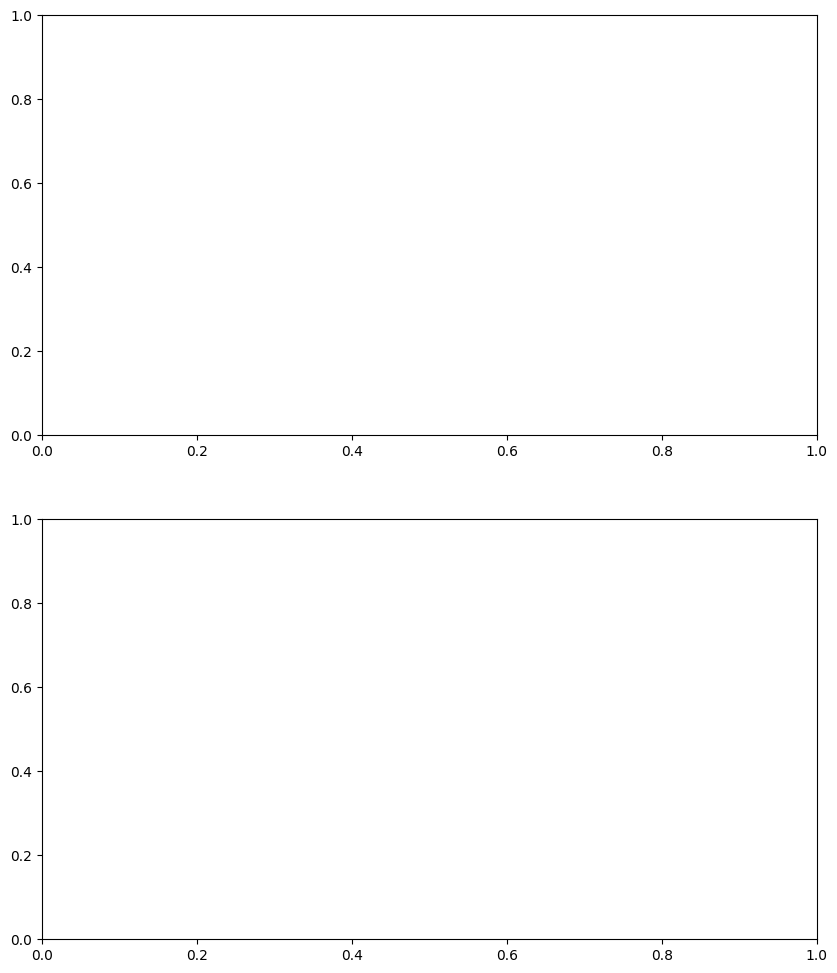

In [271]:
def plot_gp_fits(gp_fits, object_id, time_values, passbands):

    if object_id not in gp_fits:
        print(f"Object {object_id} not found in GP fits.")
        return

    gp_data = gp_fits[object_id]
    gp = gp_data["gp"]

    y_train = gp_data["flux_pred"].flatten()

    t_pred = np.linspace(min(time_values), max(time_values), 100)

    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    for band in passbands:
        t_band_pred = np.column_stack([t_pred, np.full_like(t_pred, band)])

        y_pred, var_pred = gp.predict(y_train, t_band_pred, return_var=True)
        std_dev = np.sqrt(var_pred)

        axes[0].plot(t_pred, y_pred, label=f"Passband {band}")
        axes[0].fill_between(t_pred, y_pred - std_dev, y_pred + std_dev, alpha=0.2)

    axes[0].set_title(f"GP Fit Over Time for Object {object_id}")
    axes[0].set_xlabel("Modified Julian Date (MJD)")
    axes[0].set_ylabel("Flux")
    axes[0].legend()

    sample_time_indices = np.linspace(0, len(time_values)-1, 5, dtype=int)
    for t_idx in sample_time_indices:
        t_fixed = time_values[t_idx]
        band_pred = np.column_stack([np.full_like(passbands, t_fixed), passbands])

        y_pred, var_pred = gp.predict(y_train, band_pred, return_var=True)
        std_dev = np.sqrt(var_pred)

        axes[1].plot(passbands, y_pred, marker='o', label=f"Time {t_fixed}")
        axes[1].fill_between(passbands, y_pred - std_dev, y_pred + std_dev, alpha=0.2)

    axes[1].set_title(f"GP Fit Over Passbands for Object {object_id} at Different Time Points")
    axes[1].set_xlabel("Passband")
    axes[1].set_ylabel("Flux")
    axes[1].legend()

    plt.show()


object_to_plot = list(gp_fits.keys())[0]
time_values = lcvs[lcvs["object_id"] == object_to_plot]["mjd"].unique()
passbands = np.array([0, 1, 2, 3, 4, 5])

plot_gp_fits(gp_fits, object_to_plot, time_values, passbands)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm

def plot_bell_gaussian_3d(gp_fits, object_id, time_values, passband=2):

    if object_id not in gp_fits:
        print(f"Object {object_id} not found in GP fits.")
        return

    gp_data = gp_fits[object_id]
    gp = gp_data["gp"]

    t_pred = np.linspace(min(time_values), max(time_values), 150)

    t_band_pred = np.column_stack([t_pred, np.full_like(t_pred, passband)])
    y_train = gp_data["flux_pred"].flatten()

    y_pred, var_pred = gp.predict(y_train, t_band_pred, return_var=True)
    std_dev = np.sqrt(var_pred)

    z_range = np.linspace(-3, 3, 50)
    T_grid, Z_grid = np.meshgrid(t_pred, z_range, indexing='ij')
    std_dev = std_dev[:, np.newaxis]
    bell_curve = norm.pdf(Z_grid) * std_dev + y_pred[:, np.newaxis]
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(
        T_grid, Z_grid, bell_curve, cmap="coolwarm", edgecolor='none', alpha=1.0
    )

    ax.set_xlabel("Time (Modified Julian Date - MJD)")
    ax.set_ylabel("Gaussian Standard Deviations")
    ax.set_zlabel("Flux")
    ax.set_title(f"3D Gaussian Bell-Shaped Fit for Object {object_id} - Passband {passband}")

    plt.show()

object_to_plot = list(gp_fits.keys())[0]
time_values = lcvs[lcvs["object_id"] == object_to_plot]["mjd"].unique()
passband_to_plot = 2

plot_bell_gaussian_3d(gp_fits, object_to_plot, time_values, passband=passband_to_plot)